In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shapely.wkt
import geopandas as gpd
import contextily as cx
import warnings
warnings.filterwarnings("ignore")

data_dir = '/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/GEMS/accessibility'
os.chdir(data_dir)

# part 0 -- load input

In [2]:
# load input

typology_results_2010 = read_csv('data/microtype_geotype_output_2010.csv')
typology_results_2020 = read_csv('data/microtype_geotype_output_2020.csv')
opportunity_and_jobs = read_csv('data/opportunities_and_jobs_parks.csv')
nhts_trip_rate = read_csv('data/nhts_no_ids_1hrtimebins_with_imputation_3by5.csv')
nhts_population = read_csv('data/nhts_user_classes_inc_veh_sr_3by5.csv')
#partition_data = read_csv('data/final_partition_results.csv')
tract_crosswalk = read_csv('data/census_tract_crosswalk_2010_2020.csv')
nhts_population.head(5)

,person_indx,houseid,personid,wtperfin,income,age,hhvehcnt,h_geotype,h_demand_microtype,h_network_microtype,income_over_med,income_below_med,under16,over16,male,populationgroupid
0,30000007_1,30000007,1,206.690153,7,67,5,B,Urban_industrial,Urban_2,1,0,0,1,0,HighIncVehSenior
1,30000007_2,30000007,2,197.075742,7,66,5,B,Urban_industrial,Urban_2,1,0,0,1,1,HighIncVehSenior
2,30000007_3,30000007,3,219.514210,7,28,5,B,Urban_industrial,Urban_2,1,0,0,1,0,HighIncVeh
3,30000008_1,30000008,1,63.185911,8,55,4,A,Suburban,Urban_5,1,0,0,1,1,HighIncVeh
4,30000008_2,30000008,2,58.665911,8,49,4,A,Suburban,Urban_5,1,0,0,1,0,HighIncVeh


In [4]:
# load data for typology
census_tract_boundary = gpd.read_file('data/combined_tracts_2020.geojson')
demand_typology_output = read_csv('data/clustering_outputs.csv')
print(census_tract_boundary.columns)
demand_typology_output.head(5)

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')


,pop_per_acre,jobs_per_acre,jobs_resident_bal,job_diversity,jobs_dist_bin1,jobs_dist_bin2,jobs_dist_bin3,jobs_dist_bin4,jobs_dist_bin5,remote_jobs,...,stusps,stname,cty,ctyname,trct,trctname,cbsa,cbsaname,spatial_id,demand_microtype_comb
0,-0.405118,-0.150066,-0.029750,-0.409185,0.972219,-0.633927,0.621664,-0.489713,-0.156299,-0.427714,...,AL,Alabama,1045,"Dale County, AL",1045020801,"208.01 (Dale, AL)",37120,"Ozark, AL",37120,Urban_industrial
1,-0.428868,-0.149599,-0.026969,-0.962959,-0.962415,-0.398060,1.311276,0.127229,-0.468588,-0.114493,...,AL,Alabama,1017,"Chambers County, AL",1017954200,"9542 (Chambers, AL)",29300,"LaGrange, GA-AL",29300,Suburban
2,-0.433230,-0.146776,-0.009937,-0.286267,-0.962415,-0.126366,0.178229,0.169220,0.569721,0.179761,...,AL,Alabama,1017,"Chambers County, AL",1017954300,"9543 (Chambers, AL)",29300,"LaGrange, GA-AL",29300,Suburban
3,-0.416080,-0.144815,-0.020113,0.712339,-0.087875,-1.322808,0.015233,-0.653768,2.093311,1.069868,...,AL,Alabama,1017,"Chambers County, AL",1017954700,"9547 (Chambers, AL)",29300,"LaGrange, GA-AL",29300,Urban_industrial
4,-0.262296,0.208867,0.061240,1.477805,-0.658855,-0.188459,1.040292,-0.627891,0.256625,0.737267,...,AL,Alabama,1125,"Tuscaloosa County, AL",1125011600,"116 (Tuscaloosa, AL)",46220,"Tuscaloosa, AL",46220,Urban_industrial


In [6]:
# plot demand typology in CONUS
# print(census_tract_boundary.STATEFP.unique())
state_to_drop = ['02', '15']
census_tract_boundary_conus = \
census_tract_boundary.loc[~census_tract_boundary['STATEFP'].isin(state_to_drop)]

demand_typology_output.loc[:, 'GEOID'] = \
demand_typology_output.loc[:, 'trct'].astype(str).str.zfill(11)
to_drop = ['demand_microtype', 'tract',
       'census_urban_area', 'V1', 'st', 'stusps', 'stname', 'cty', 'ctyname',
       'trct', 'trctname', 'cbsa', 'cbsaname', 'spatial_id']
demand_typology_output.drop(columns = to_drop, 
                            inplace = True)
census_tract_boundary_conus = \
census_tract_boundary_conus.merge(demand_typology_output, on = 'GEOID',
                                 how = 'left')
print(len(census_tract_boundary_conus))
census_tract_boundary_conus.head(5)

83776


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,jobs_dist_bin1,jobs_dist_bin2,jobs_dist_bin3,jobs_dist_bin4,jobs_dist_bin5,remote_jobs,job_sink_mag,impervious_developed,developed_open_space,demand_microtype_comb
0,01,045,020801,01045020801,208.01,Census Tract 208.01,G5020,S,19261326.0,0.0,...,0.972219,-0.633927,0.621664,-0.489713,-0.156299,-0.427714,-0.183417,-0.934735,-0.175584,Urban_industrial
1,01,017,954200,01017954200,9542,Census Tract 9542,G5020,S,62998696.0,34641.0,...,-0.962415,-0.398060,1.311276,0.127229,-0.468588,-0.114493,-0.156975,-1.263163,-0.443479,Suburban
2,01,017,953800,01017953800,9538,Census Tract 9538,G5020,S,515692207.0,11516898.0,...,-0.962415,-1.322808,0.798021,1.131962,-0.204995,-0.872753,-0.180377,-1.299566,-0.556717,Rural_agriculture
3,01,017,954300,01017954300,9543,Census Tract 9543,G5020,S,132642536.0,178276.0,...,-0.962415,-0.126366,0.178229,0.169220,0.569721,0.179761,0.008073,-1.150635,-0.473857,Suburban
4,01,017,954700,01017954700,9547,Census Tract 9547,G5020,S,38036820.0,264376.0,...,-0.087875,-1.322808,0.015233,-0.653768,2.093311,1.069868,-0.097736,-1.124511,-0.405751,Urban_industrial


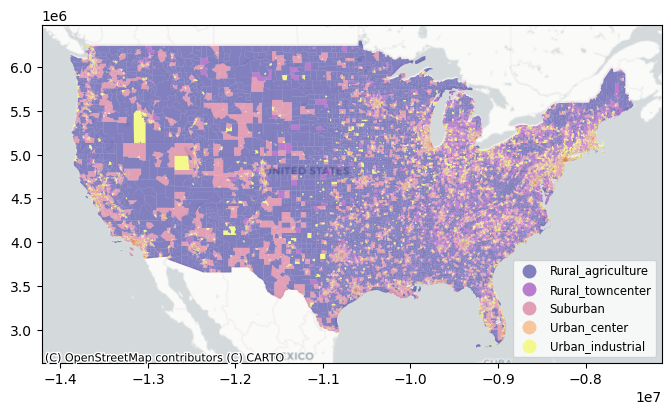

In [11]:
census_tract_boundary_conus = census_tract_boundary_conus.to_crs("EPSG:3395")
ax = census_tract_boundary_conus.plot(figsize = (8,6), 
                                      column = 'demand_microtype_comb', 
                                      alpha = 0.5, legend=True,
                                      cmap= 'plasma',linewidth=0.01,
                                      legend_kwds={'loc': 'lower right',
                                                  'fontsize': 'small'})
cx.add_basemap(ax, crs = 'EPSG:3395',source = cx.providers.CartoDB.Positron)
plt.savefig('plot/CONUS_demand_microtype.png', dpi = 300, bbox_inches = 'tight')

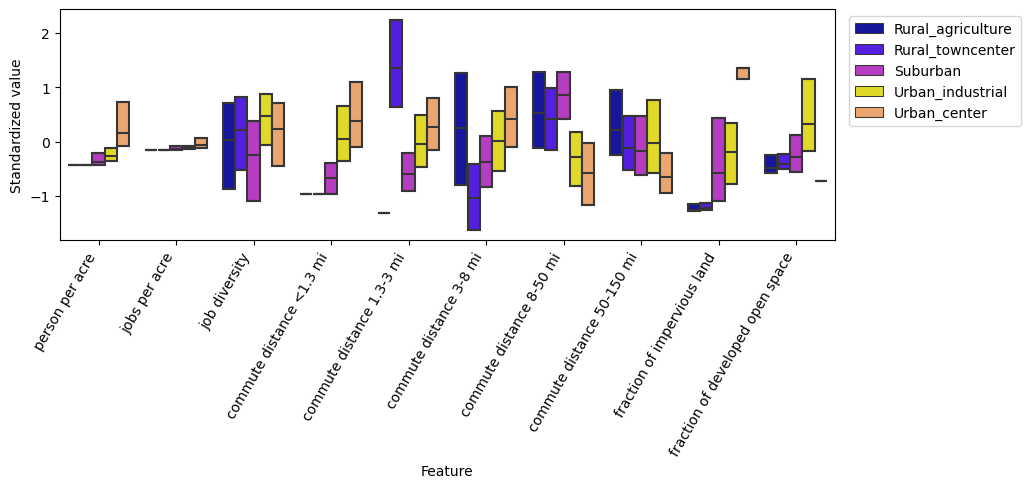

In [7]:
demand_typology_output.columns = ['person per acre', 'jobs per acre', 
                                  'jobs resident bal', 'job diversity',
                                  'commute distance <1.3 mi', 
                                  'commute distance 1.3-3 mi', 
                                  'commute distance 3-8 mi', 
                                  'commute distance 8-50 mi',
                                  'commute distance 50-150 mi', 
                                  'remote jobs', 'job sink mag', 
                                  'fraction of impervious land',
                                  'fraction of developed open space', 
                                  'socioeconomic microtype', 'GEOID']
demand_typology_output_long = pd.melt(demand_typology_output,
                                     id_vars = ['GEOID', 'socioeconomic microtype'], 
                                      var_name='Feature', 
                                      value_name='Standardized value')
demand_typology_output_long.head(5)

palette = ["#0000B3FF", "#4500FFFF", "#C527D8FF", "#FFF50AFF", "#FFA35CFF"]
plt.figure(figsize = (10,3))
order_of_feature = ['person per acre', 'jobs per acre', 
                                  'job diversity',
                                  'commute distance <1.3 mi', 
                                  'commute distance 1.3-3 mi', 
                                  'commute distance 3-8 mi', 
                                  'commute distance 8-50 mi',
                                  'commute distance 50-150 mi', 
                                  'fraction of impervious land',
                                  'fraction of developed open space']
order_of_type = ['Rural_agriculture', 'Rural_towncenter',
                 'Suburban', 'Urban_industrial', 'Urban_center']
demand_typology_output_long = \
demand_typology_output_long.loc[demand_typology_output_long['Feature'].isin(order_of_feature)]
sns.boxplot(data=demand_typology_output_long, 
            x="Feature", y="Standardized value", 
            hue="socioeconomic microtype", order = order_of_feature,
            hue_order = order_of_type, whis = 0,
            palette=sns.color_palette(palette, 5),
            showfliers = False)
plt.xticks(rotation = 60, ha = 'right')
plt.legend(bbox_to_anchor = (1.01,1))
plt.savefig('plot/demand_typology_feature.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [28]:
demand_typology_output.columns

Index(['pop_per_acre', 'jobs_per_acre', 'jobs_resident_bal', 'job_diversity',
       'jobs_dist_bin1', 'jobs_dist_bin2', 'jobs_dist_bin3', 'jobs_dist_bin4',
       'jobs_dist_bin5', 'remote_jobs', 'job_sink_mag', 'impervious_developed',
       'developed_open_space', 'demand_microtype_comb', 'GEOID'],
      dtype='object')

In [3]:
# check partition
print(len(partition_data))
print(len(partition_data.unitedID.unique()))
cbsa_by_partition = \
partition_data.groupby('unitedID')[['cbsa']].nunique()
cbsa_by_partition = cbsa_by_partition.reset_index()
cbsa_by_partition.head(5)

unique_partition = \
partition_data.groupby(['unitedID', 'cbsa']).size()

unique_partition = unique_partition.reset_index()
unique_partition.columns = ['unitedID', 'cbsa', 'num_of_tract']
print(len(unique_partition))
unique_partition.head(5)

count_of_tract_group = unique_partition.groupby(['num_of_tract']).size()
count_of_tract_group = count_of_tract_group.reset_index()
count_of_tract_group.columns = ['number of tract in partition',
                               'number of partitions']
count_of_tract_group.loc[:, 'fraction of partition'] = \
count_of_tract_group.loc[:, 'number of partitions']/ \
count_of_tract_group.loc[:, 'number of partitions'].sum()
count_of_tract_group.to_csv('data/partition_count_to_check.csv')

42425
16116
23482


In [6]:
tract_crosswalk_short = tract_crosswalk[['GEOID_TRACT_20', 'GEOID_TRACT_10']]

partition_data_2010 = pd.merge(partition_data,
                               tract_crosswalk_short,
                               left_on = 'GEOID',
                               right_on = 'GEOID_TRACT_20',
                               how = 'left')
print(len(partition_data_2010))
partition_data_2010 = \
partition_data_2010.drop_duplicates(subset = 'GEOID_TRACT_10',
                                    keep = 'first')
print(len(partition_data_2010))
partition_data_2010.head(10)


unique_partition_2010 = \
partition_data_2010.groupby(['unitedID', 'cbsa']).size()

unique_partition_2010 = unique_partition_2010.reset_index()
unique_partition_2010.columns = ['unitedID', 'cbsa', 'num_of_tract']
print(len(unique_partition_2010))
unique_partition_2010.head(5)

count_of_tract_group_2010 = unique_partition_2010.groupby(['num_of_tract']).size()
count_of_tract_group_2010 = count_of_tract_group_2010.reset_index()
count_of_tract_group_2010.columns = ['number of tract in partition',
                               'number of partitions']
count_of_tract_group_2010.loc[:, 'fraction of partition'] = \
count_of_tract_group_2010.loc[:, 'number of partitions']/ \
count_of_tract_group_2010.loc[:, 'number of partitions'].sum()
count_of_tract_group_2010.to_csv('data/partition_count_to_check_2010.csv')
partition_data_2010.to_csv('data/final_partition_results_2010.csv')

58977
40105
21276


In [8]:
# define parameters
order_demand = ['Rural_agriculture', 'Rural_towncenter', 
                'Suburban', 'Urban_industrial', 'Urban_center']
order_geotype = ['A', 'B', 'C', 'D']
order_network = ['Rural_1', 'Rural_2', 'Rural_3',
                 'Urban_1', 'Urban_2', 'Urban_3', 'Urban_4', 'Urban_5']

In [ ]:
cmap = cm.get_cmap('seismic', 3)    # PiYG

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))

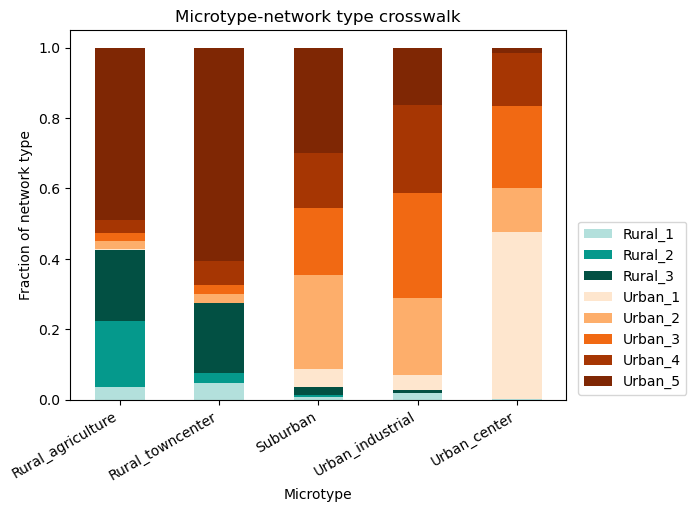

In [29]:
# typology cross tab
# from colour import Color
# from matplotlib.colors import LinearSegmentedColormap

network_by_demand = \
pd.pivot_table(typology_results_2020, 
               index = 'demand_microtype',
               columns = 'network_microtype', 
               values = 'GEOID',
               aggfunc = 'count')

# network_by_demand = network_by_demand.reset_index()
net_palette = ['#b3e0dc','#05998c', '#025043', # rural blues
               "#fee6ce", "#fdae6b", "#f16913", "#a63603", "#7f2704"]
net_cmap = ListedColormap(net_palette)
# color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in net_palette ] )
network_by_demand_frac = network_by_demand.copy()
class_label = typology_results_2020.network_microtype.unique()
network_by_demand_frac = network_by_demand_frac.loc[order_demand]
network_by_demand_frac.loc[:, class_label] = \
    network_by_demand_frac.loc[:, class_label].div(network_by_demand_frac.loc[:, class_label].sum(axis=1), axis=0)

network_by_demand_frac.plot(kind = 'bar', stacked = True, 
                            colormap=net_cmap)
plt.xticks(rotation = 30, ha = 'right')
plt.legend(bbox_to_anchor = (1.01, 0.5))
plt.ylabel('Fraction of network type')
plt.xlabel('Microtype')
plt.title('Microtype-network type crosswalk')
plt.savefig('plot/demand_network_typology_crosswalk.png', dpi = 300,
           bbox_inches = 'tight')                            
plt.show()

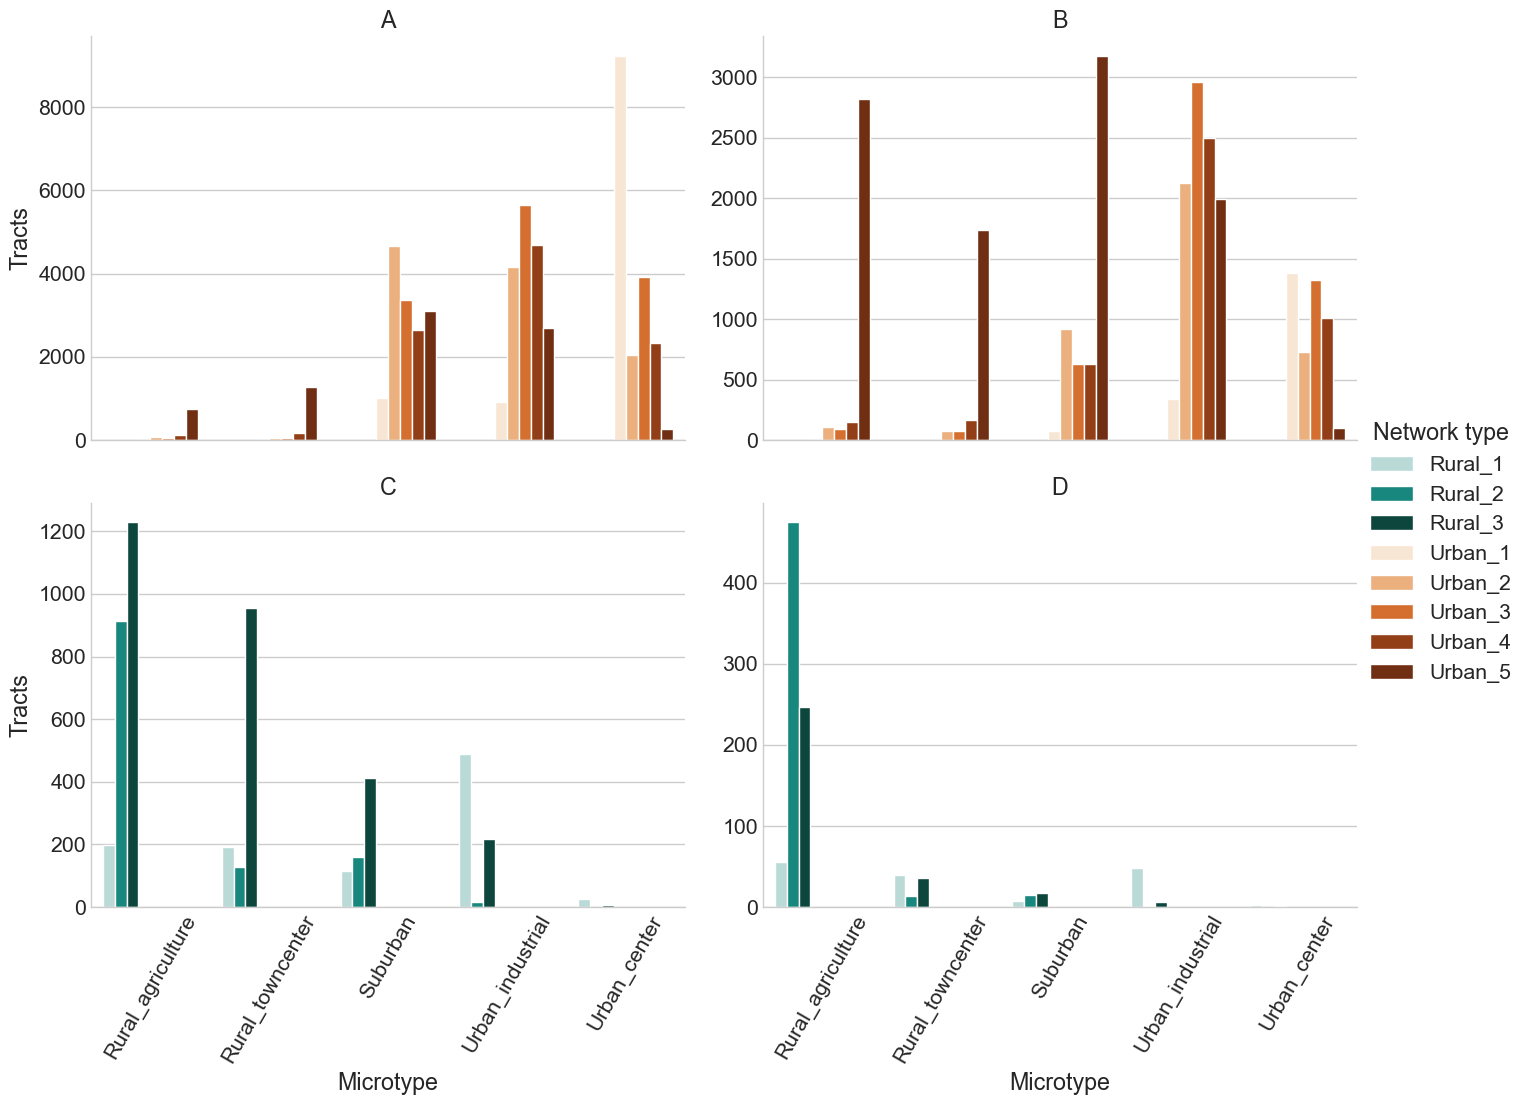

In [81]:
network_by_demand_net = \
typology_results_2020.groupby(['geotype','demand_microtype', 'network_microtype'])[['GEOID']].count()
network_by_demand_net = network_by_demand_net.reset_index()
network_by_demand_net.columns = ['Geotype','Microtype', 'Network type', 'Tracts']
network_by_demand_net.head(5)
plt.style.use('seaborn-v0_8-whitegrid')
ax = sns.catplot(data = network_by_demand_net, 
            x="Microtype", y="Tracts", hue = 'Network type', col="Geotype", 
            col_wrap = 2, kind="bar", 
            hue_order = order_network,
            order = order_demand,
            palette = sns.color_palette(net_palette, 8),
            height = 5, aspect = 1.4, sharey = False)
ax.set_titles("{col_name}")
# plt.xticks(rotation = 90, ha= 'right')
for axn in ax.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(60)
plt.savefig('plot/number_of_tract_by_geotype_network_demand.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

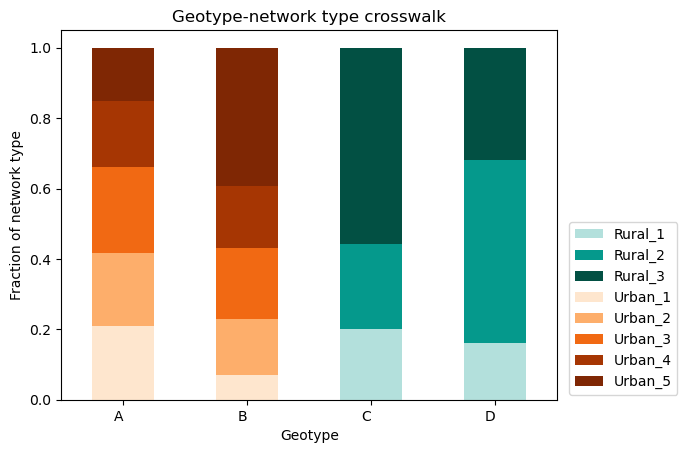

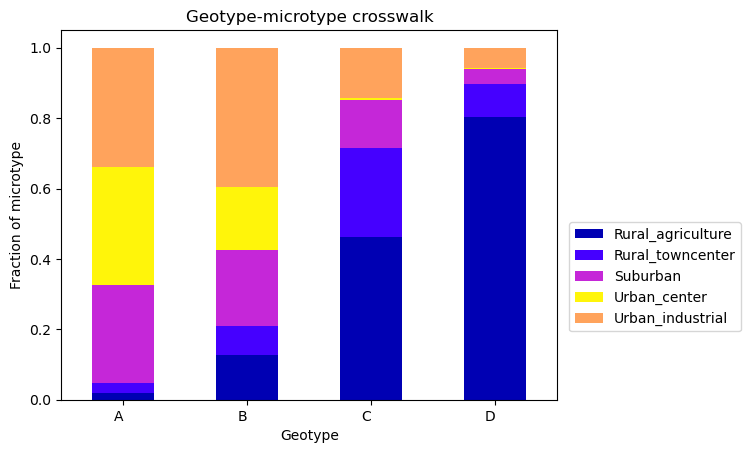

In [32]:
# typology cross tab
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
demand_cmap = ListedColormap(palette)


network_by_geotype = \
pd.pivot_table(typology_results_2020, 
               index = 'geotype',
               columns = 'network_microtype', 
               values = 'GEOID',
               aggfunc = 'count')

# network_by_demand = network_by_demand.reset_index()

network_by_geotype_frac = network_by_geotype.copy()
class_label = typology_results_2020.network_microtype.unique()
network_by_geotype_frac.loc[:, class_label] = \
    network_by_geotype_frac.loc[:, class_label].div(network_by_geotype_frac.loc[:, class_label].sum(axis=1), axis=0)

network_by_geotype_frac.plot(kind = 'bar', stacked = True, colormap=net_cmap)
plt.xticks(rotation = 0, ha = 'right')
plt.legend(bbox_to_anchor = (1.01, 0.5))
plt.ylabel('Fraction of network type')
plt.xlabel('Geotype')
plt.title('Geotype-network type crosswalk')
plt.savefig('plot/geotype_network_typology_crosswalk.png', dpi = 300,
           bbox_inches = 'tight')                            
plt.show()

# typology cross tab -demand
demand_by_geotype = \
pd.pivot_table(typology_results_2020, 
               index = 'geotype',
               columns = 'demand_microtype', 
               values = 'GEOID',
               aggfunc = 'count')

# network_by_demand = network_by_demand.reset_index()

demand_by_geotype_frac = demand_by_geotype.copy()
class_label = typology_results_2020.demand_microtype.unique()
demand_by_geotype_frac.loc[:, class_label] = \
    demand_by_geotype_frac.loc[:, class_label].div(demand_by_geotype_frac.loc[:, class_label].sum(axis=1), axis=0)

demand_by_geotype_frac.plot(kind = 'bar', stacked = True, colormap=demand_cmap)
plt.xticks(rotation = 0, ha = 'right')
plt.legend(bbox_to_anchor = (1.01, 0.5))
plt.ylabel('Fraction of microtype')
plt.xlabel('Geotype')
plt.title('Geotype-microtype crosswalk')
plt.savefig('plot/geotype_demand_typology_crosswalk.png', dpi = 300,
           bbox_inches = 'tight')                            
plt.show()

# part 1 - explore opportunity

Index(['GEOID', 'ALAND', 'religion', 'childcare', 'university', 'bank',
       'hospital', 'nursing_home', 'pharmacy', 'private_school',
       'public_school', 'urgent_care', 'va_medical', 'office_jobs',
       'retail_jobs', 'industry_jobs', 'service_jobs', 'recreation_jobs',
       'education_jobs', 'healthcare_jobs', 'government_jobs', 'total_jobs',
       'park_area', 'park_count', 'park_area_frac', 'medical', 'school',
       'other', 'geotype', 'network_microtype', 'demand_microtype', 'st_code',
       'cbsa', 'cbsaname', 'geotype_V1', 'microtype_V1'],
      dtype='object')


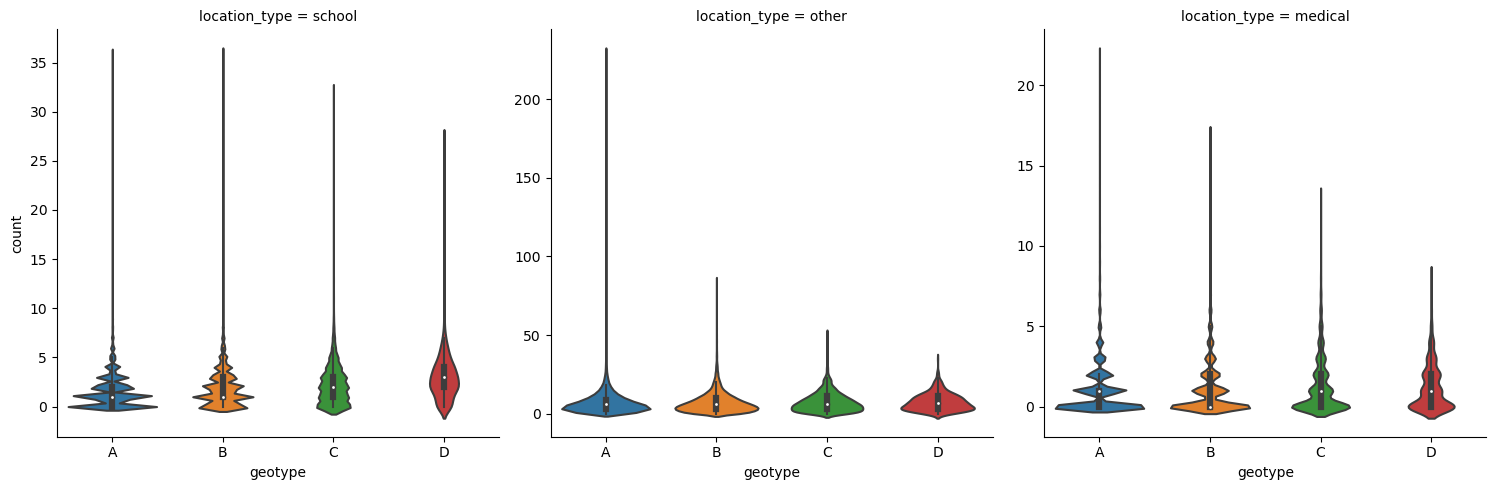

In [35]:
# explore opportunity (using 2010 boundary)
opp_mapping = {'medical': ['hospital','pharmacy', 'urgent_care', 'va_medical'],
'school': ['private_school','public_school'],
'other':  ['religion', 'childcare','bank','nursing_home']}
opportunity_and_jobs.loc[:, 'medical'] = \
opportunity_and_jobs.loc[:, opp_mapping['medical']].sum(axis= 1)

opportunity_and_jobs.loc[:, 'school'] = \
opportunity_and_jobs.loc[:, opp_mapping['school']].sum(axis= 1)

opportunity_and_jobs.loc[:, 'other'] = \
opportunity_and_jobs.loc[:, opp_mapping['other']].sum(axis= 1)

opportunity_and_jobs_typology = pd.merge(opportunity_and_jobs,
                                        typology_results_2010,
                                        on = 'GEOID', how = 'left')

# opportunity_and_jobs_typology.head(5)
print(opportunity_and_jobs_typology.columns)
location_var = ['medical', 'school', 'other']

job_var = ['office_jobs', 'retail_jobs', 'industry_jobs', 
           'service_jobs', 'recreation_jobs',
       'education_jobs', 'healthcare_jobs', 'government_jobs']

opportunity_by_location = pd.melt(opportunity_and_jobs_typology, 
                                 id_vars = ['GEOID', 'geotype', 'demand_microtype', 'network_microtype'],
                                 value_vars = location_var,
                                 var_name= 'location_type', 
                                  value_name='count')

opportunity_by_location = \
opportunity_by_location.sort_values(by = 'geotype')

sns.catplot(data = opportunity_by_location, 
            x="geotype", y="count", col="location_type", 
            col_wrap = 4, kind="violin", sharey = False)

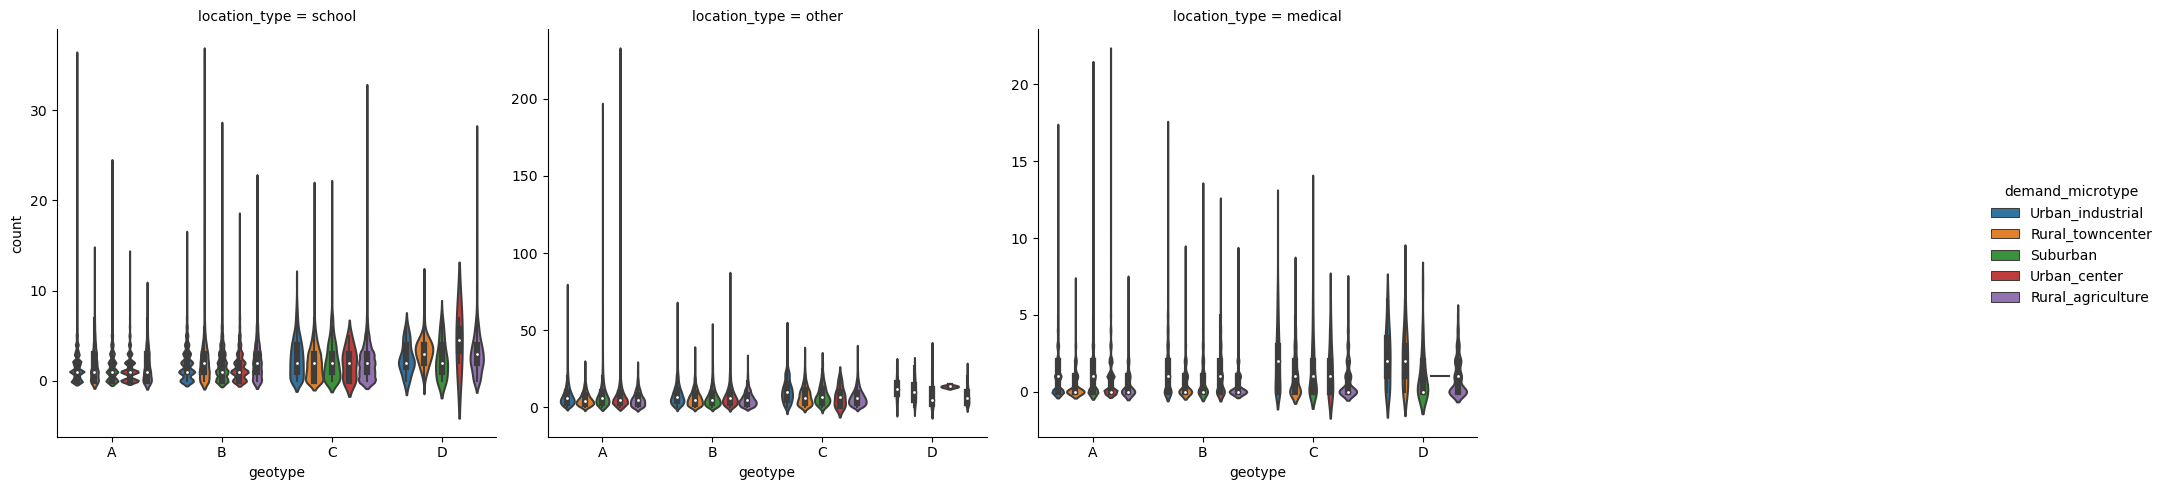

In [36]:
# opportunity_by_location = \
# opportunity_by_location.rename(columns = {'demand_microtype_comb': 'demand_microtype'})
sns.catplot(data = opportunity_by_location, 
            x="geotype", y="count", hue = 'demand_microtype', col="location_type", 
            col_wrap = 4, kind="violin", sharey = False)

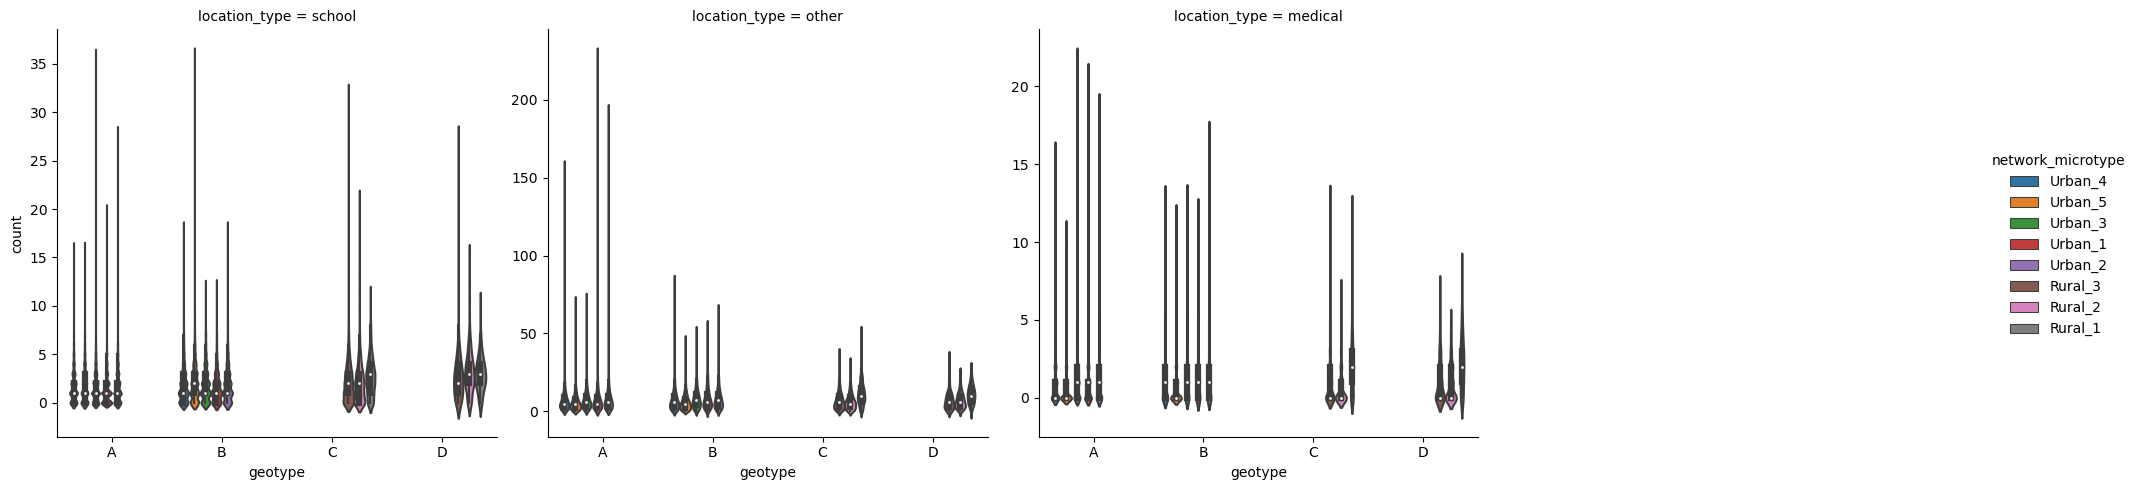

In [37]:
sns.catplot(data = opportunity_by_location, 
            x="geotype", y="count", hue = 'network_microtype', col="location_type", 
            col_wrap = 4, kind="violin", sharey = False)

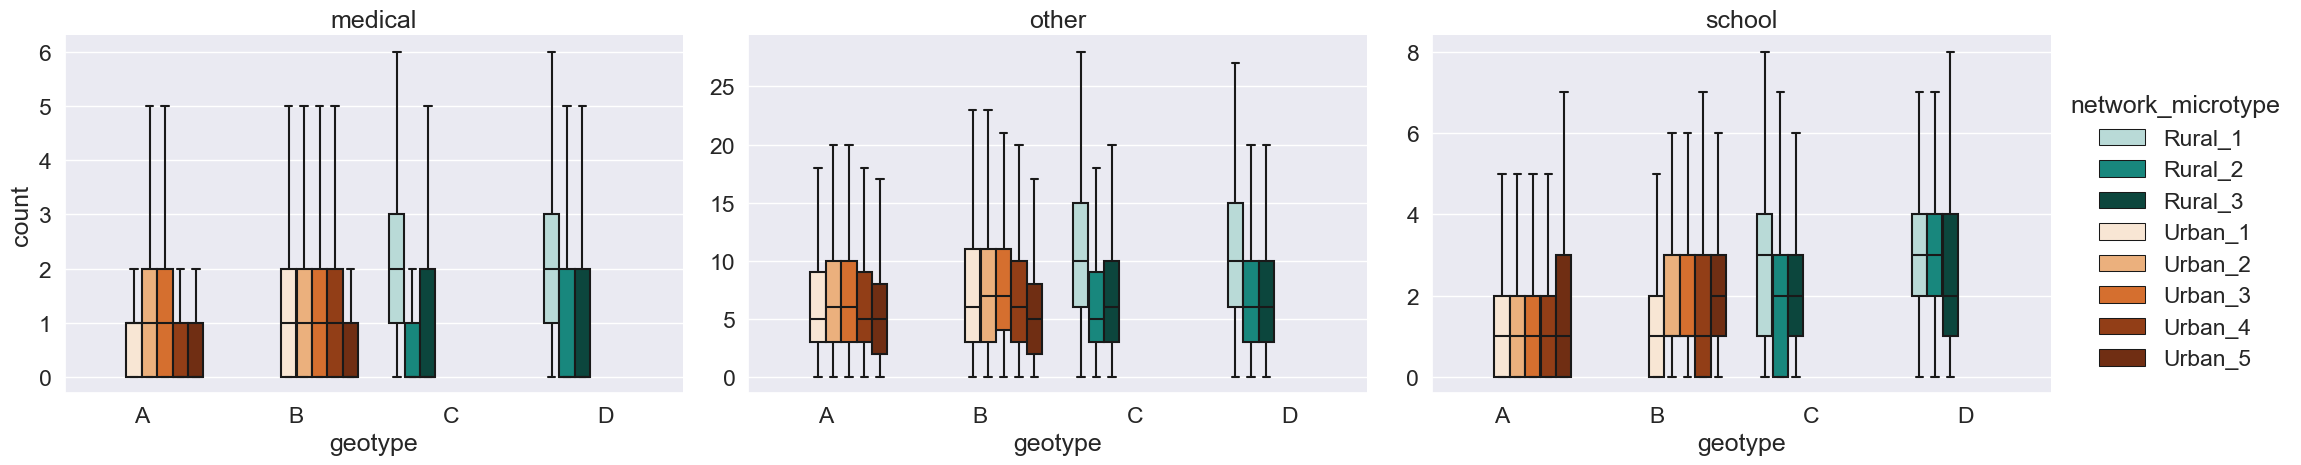

In [47]:
sns.set(font_scale=1.5)  # crazy big
# sns.color_palette(palette, 5)
order_demand = ['Rural_agriculture', 'Rural_towncenter', 
                'Suburban', 'Urban_industrial', 'Urban_center']
order_geotype = ['A', 'B', 'C', 'D']
order_network = ['Rural_1', 'Rural_2', 'Rural_3',
                 'Urban_1', 'Urban_2', 'Urban_3', 'Urban_4', 'Urban_5' ]
net_palette = ['#b3e0dc','#05998c', '#025043', # rural blues
               "#fee6ce", "#fdae6b", "#f16913", "#a63603", "#7f2704"]
opportunity_by_location = \
opportunity_by_location.sort_values(by = 'location_type')
ax = sns.catplot(data = opportunity_by_location, 
            x="geotype", y="count", hue = 'network_microtype', col="location_type", 
            col_wrap = 3, kind="box", 
            hue_order = order_network,
            order = order_geotype,
            showfliers = False, palette = sns.color_palette(net_palette, 8),
            height = 5, aspect = 1.4, sharey = False)
ax.set_titles("{col_name}")
plt.xticks(rotation = 90, ha= 'right')
for axn in ax.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(0)
plt.savefig('plot/location_by_geotype_network.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

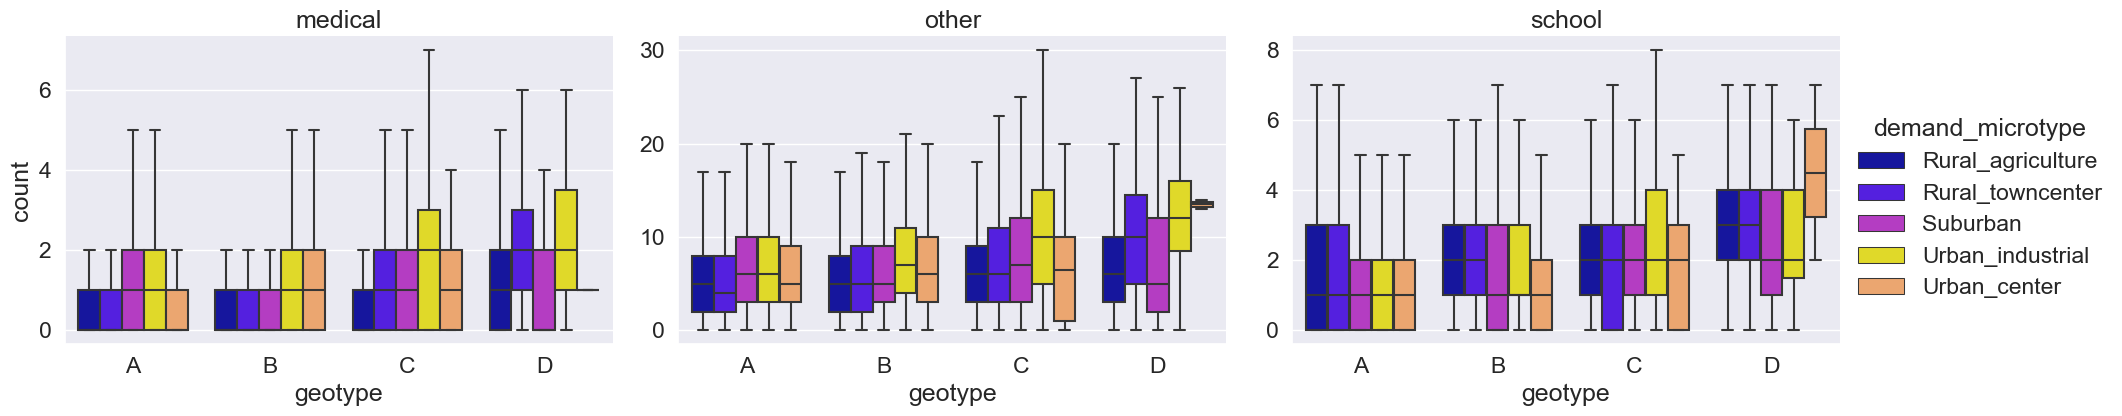

In [48]:
# order_of_col = ['Rural_agriculture', 'Rural_towncenter', 'Urban_industrial', 'Suburban', 
#        'Urban_center']
opportunity_by_location = \
opportunity_by_location.sort_values(by = 'location_type')

ax = sns.catplot(data = opportunity_by_location, 
            x="geotype", y="count", hue = 'demand_microtype', col="location_type",
            hue_order = order_demand,
            order = order_geotype, palette = sns.color_palette(palette, 5),
            col_wrap = 3, kind="box", height = 4.5, aspect = 1.4, 
            showfliers = False, sharey = False)
ax.set_titles("{col_name}")
# plt.xticks(rotation = 90, ha= 'right')
for axn in ax.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(0)
plt.savefig('plot/location_by_geotype_demand.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

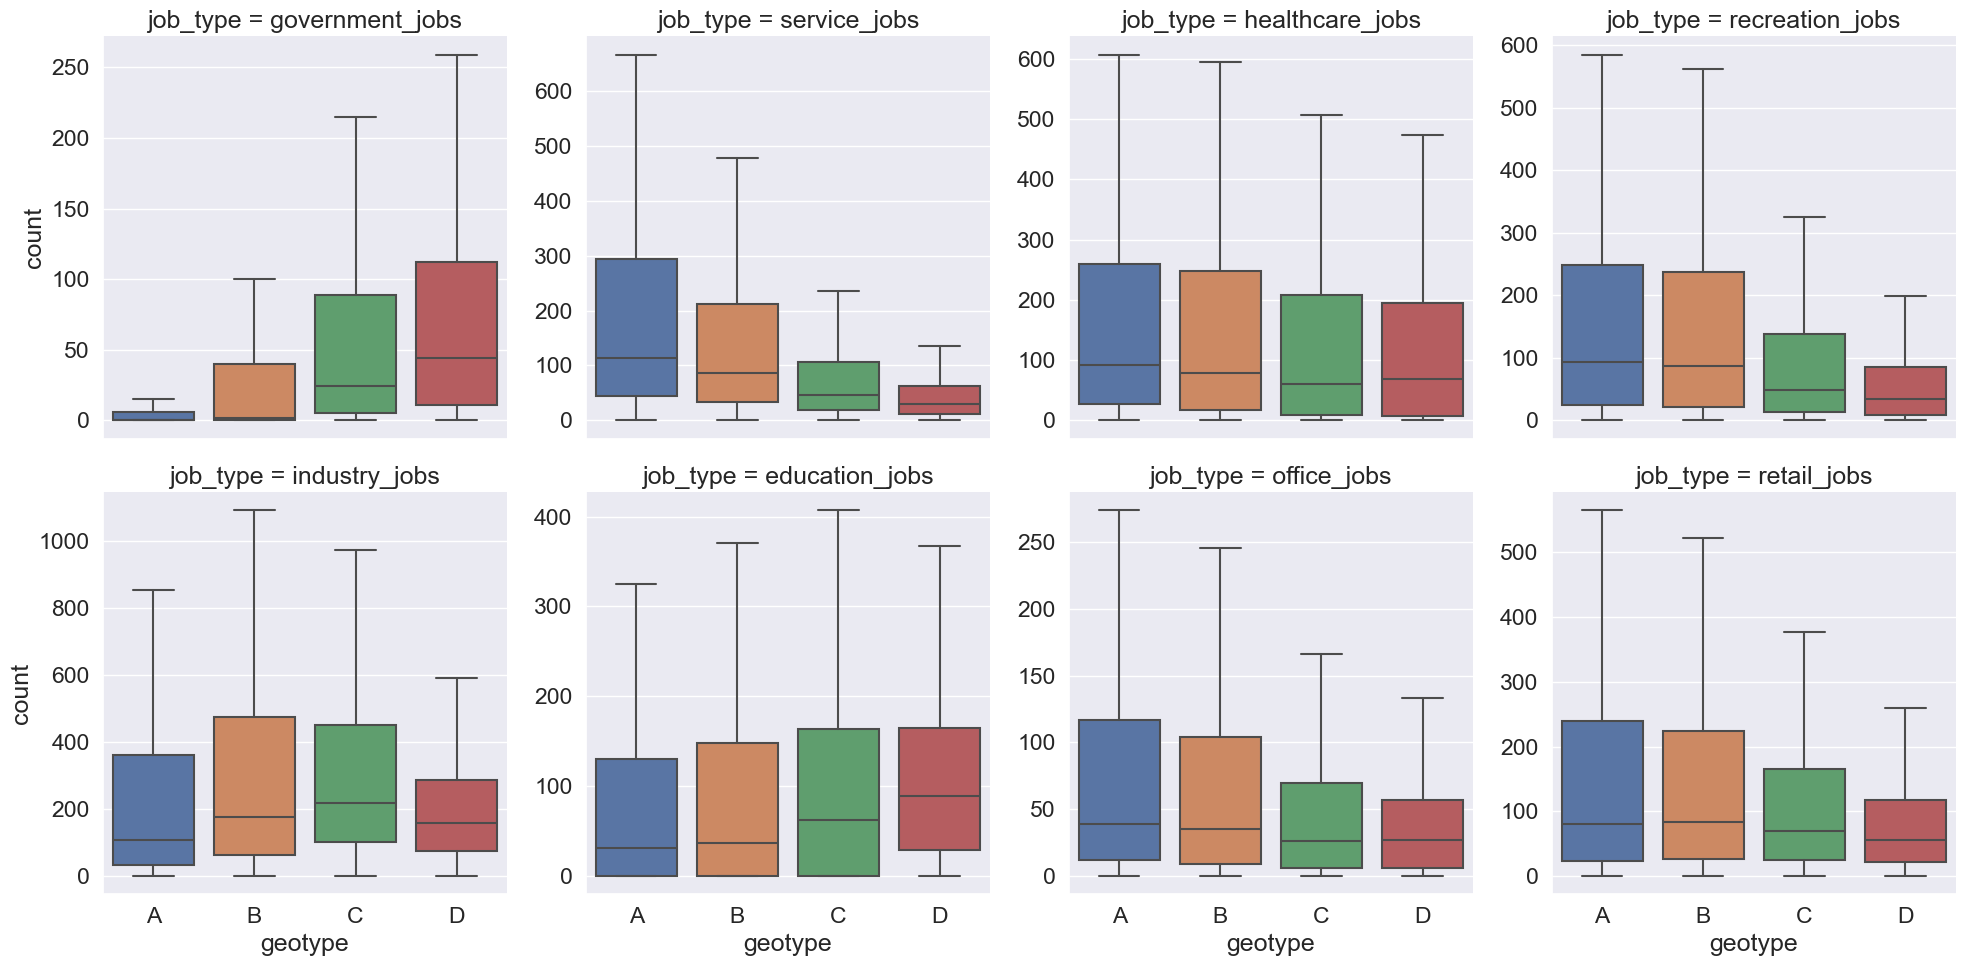

In [50]:
geotype_palette = ['#E76F51', '#2A9D8F', '#264653', '#E9C46A']
job_by_location = pd.melt(opportunity_and_jobs_typology,
                          id_vars = ['GEOID', 'geotype', 'demand_microtype', 'network_microtype'],
                          value_vars = job_var,
                          var_name= 'job_type', 
                          value_name='count')

job_by_location = \
job_by_location.sort_values(by = 'geotype')
# job_by_location = job_by_location.rename(columns = {'demand_microtype_comb': 'demand_microtype'})

sns.catplot(data = job_by_location, 
            x="geotype", y="count", col="job_type", 
            col_wrap = 4, kind="box", showfliers = False, sharey = False)

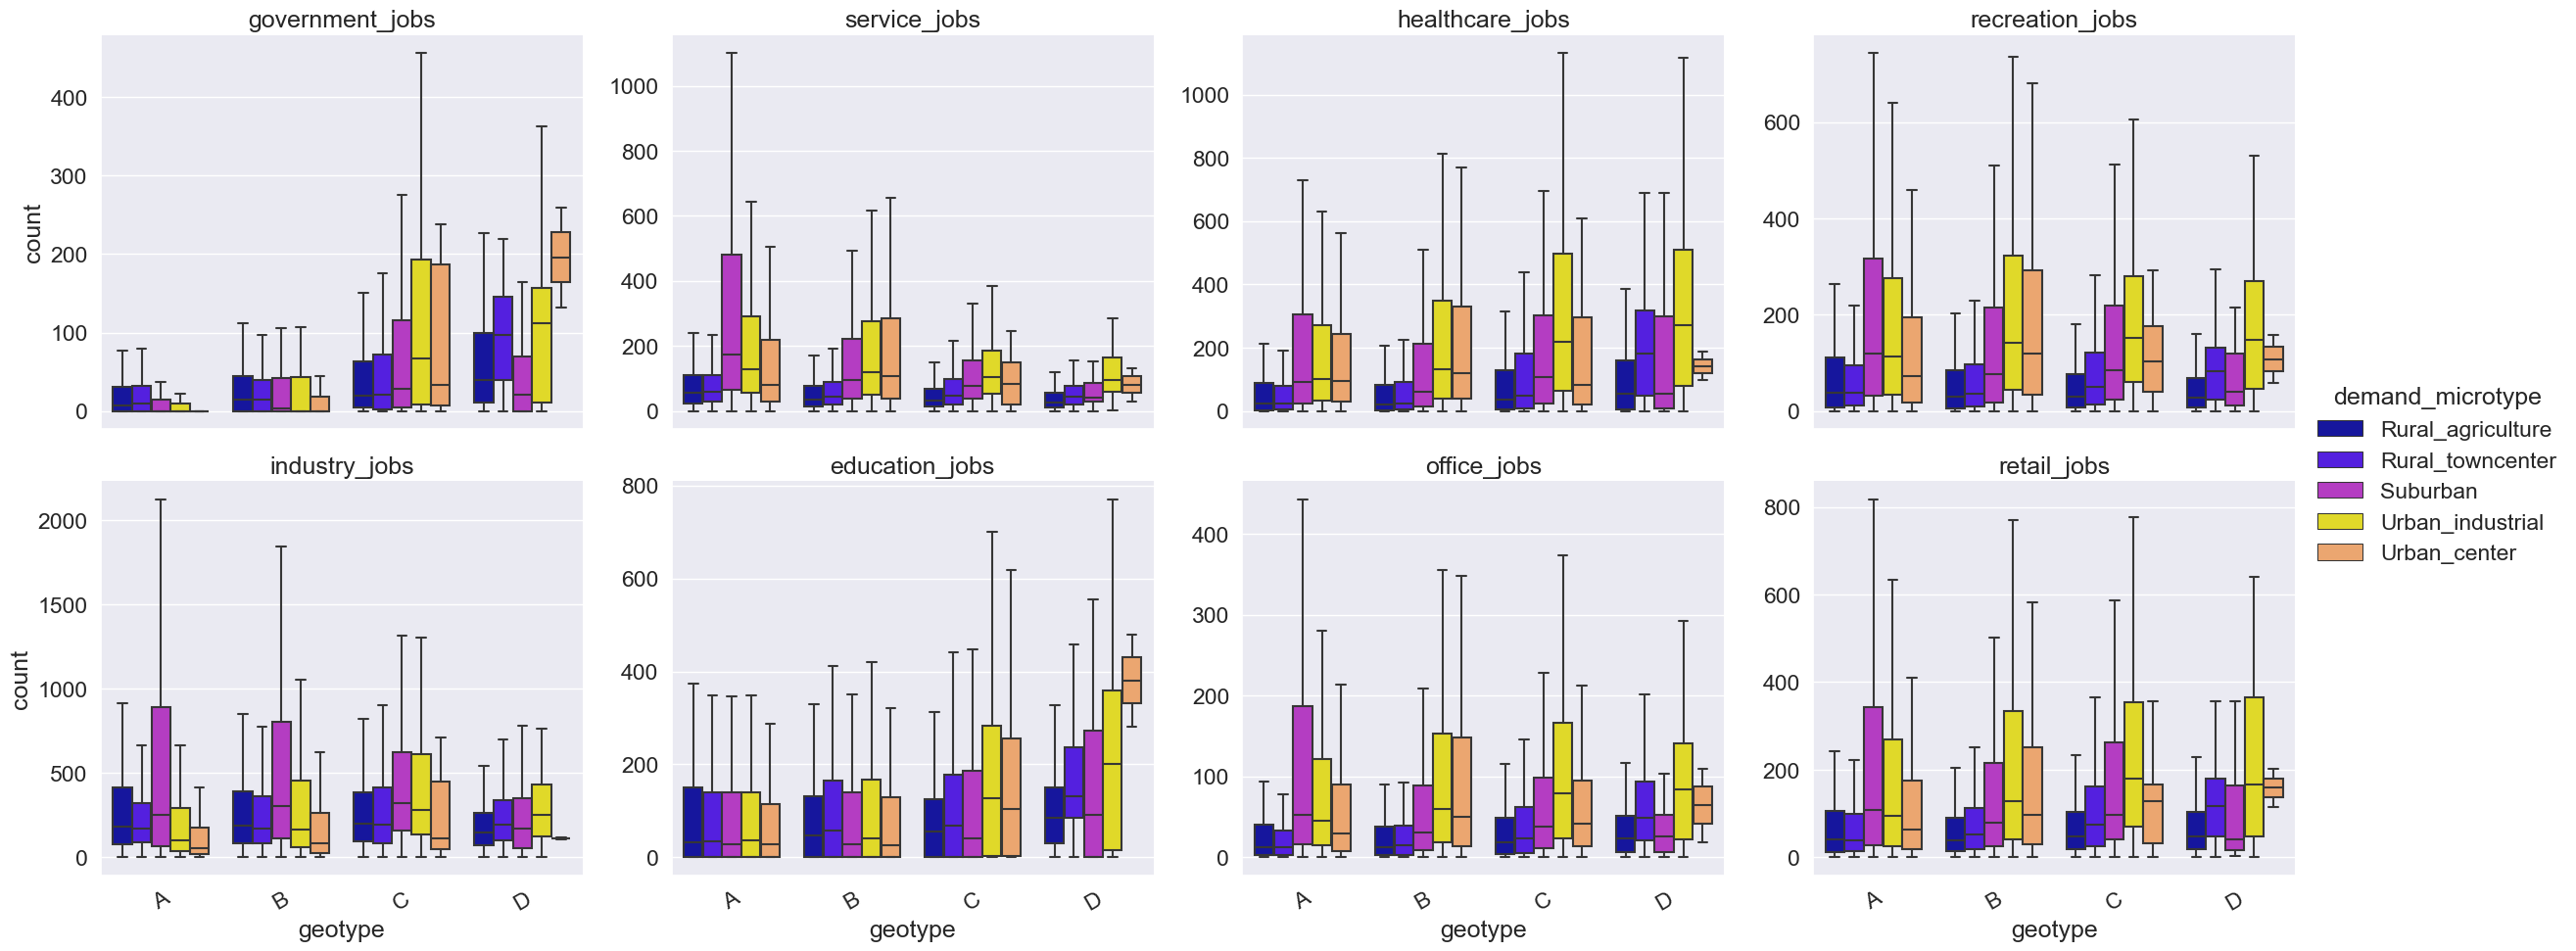

In [51]:

ax = sns.catplot(data = job_by_location, 
            hue_order = order_demand,
            order = order_geotype,
            x="geotype", y="count", hue = 'demand_microtype', col="job_type", 
            col_wrap = 4, kind="box", palette = sns.color_palette(palette, 5),
            height = 5, aspect = 1.2, 
            showfliers = False, sharey = False)
ax.set_titles("{col_name}")
# plt.xticks(rotation = 30, ha= 'right')
for axn in ax.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(30)
plt.savefig('plot/job_by_geotype_demand.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

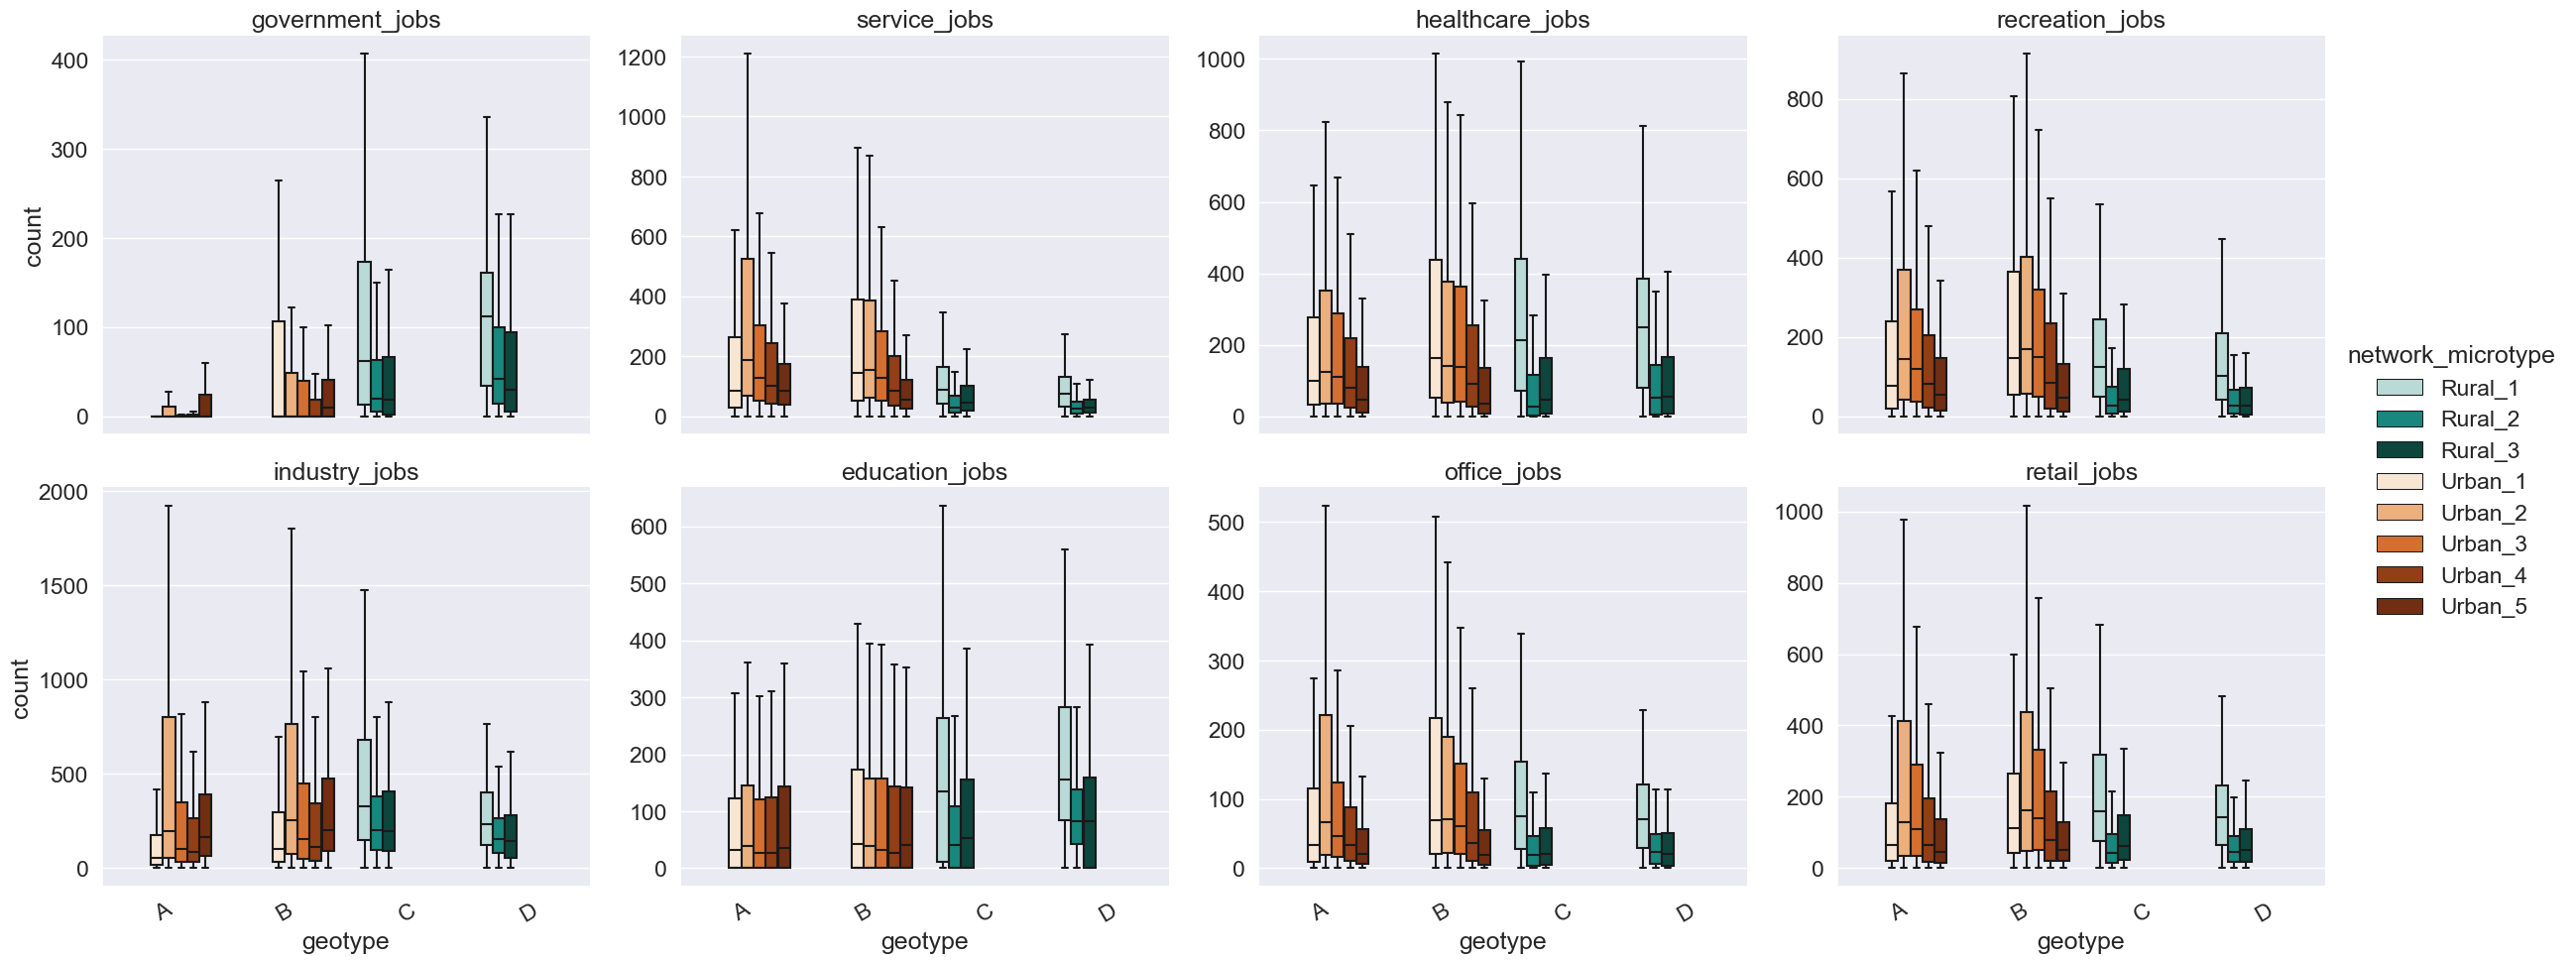

In [52]:
ax = sns.catplot(data = job_by_location, 
            x="geotype", y="count", hue = 'network_microtype', col="job_type", 
            col_wrap = 4, kind="box", palette = sns.color_palette(net_palette, 8),           
            hue_order = order_network,
            order = order_geotype,
            height = 5, aspect = 1.2, 
            showfliers = False, sharey = False)
ax.set_titles("{col_name}")
# plt.xticks(rotation = 30, ha= 'right')
for axn in ax.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(30)
plt.savefig('plot/job_by_geotype_network.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

Index(['GEOID', 'ALAND', 'religion', 'childcare', 'university', 'bank',
       'hospital', 'nursing_home', 'pharmacy', 'private_school',
       'public_school', 'urgent_care', 'va_medical', 'office_jobs',
       'retail_jobs', 'industry_jobs', 'service_jobs', 'recreation_jobs',
       'education_jobs', 'healthcare_jobs', 'government_jobs', 'total_jobs',
       'park_area', 'park_count', 'park_area_frac', 'medical', 'school',
       'other', 'geotype', 'network_microtype', 'demand_microtype', 'st_code',
       'cbsa', 'cbsaname', 'geotype_V1', 'microtype_V1'],
      dtype='object')


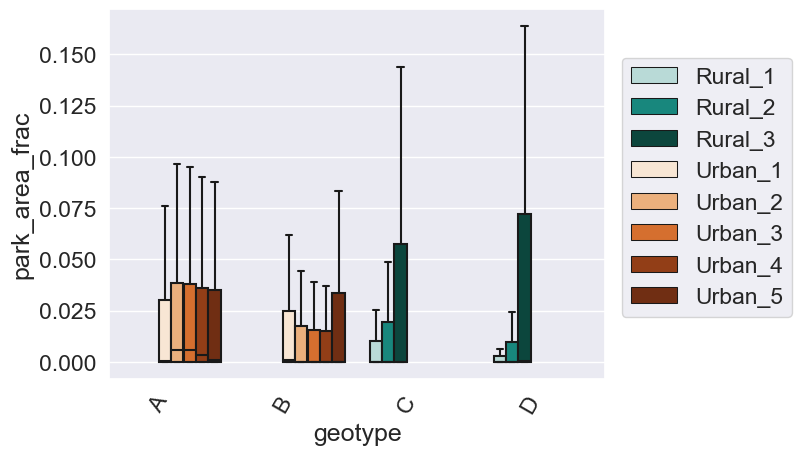

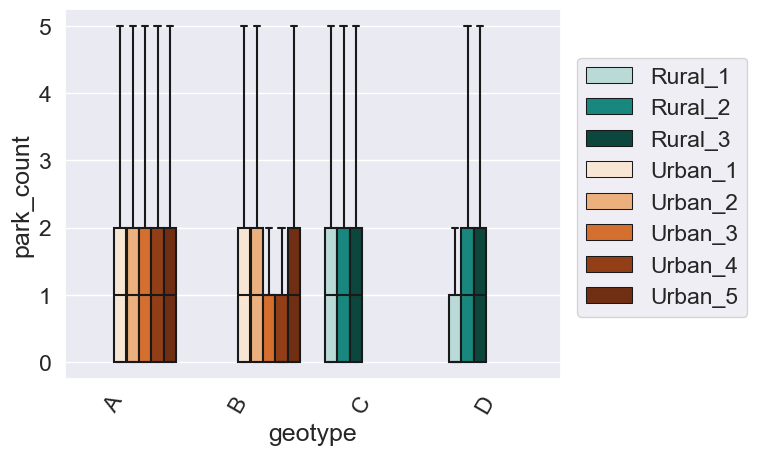

In [55]:
# park coverage
print(opportunity_and_jobs_typology.columns)
sns.boxplot(data = opportunity_and_jobs_typology, 
            x="geotype", y="park_area_frac", 
            hue = 'network_microtype',        
            hue_order = order_network,
            order = order_geotype, palette = sns.color_palette(net_palette, 8),
            showfliers = False)
plt.legend(bbox_to_anchor = (1.01, 0.9))
plt.xticks(rotation = 60, ha = 'right')
plt.savefig('plot/parks_area_frac_by_geotype_network.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

sns.boxplot(data = opportunity_and_jobs_typology, 
            x="geotype", y="park_count", 
            hue = 'network_microtype',        
            hue_order = order_network,
            order = order_geotype, palette = sns.color_palette(net_palette, 8),
            showfliers = False)
plt.legend(bbox_to_anchor = (1.01, 0.9))
plt.xticks(rotation = 60, ha = 'right')
plt.savefig('plot/parks_count_by_geotype_network.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

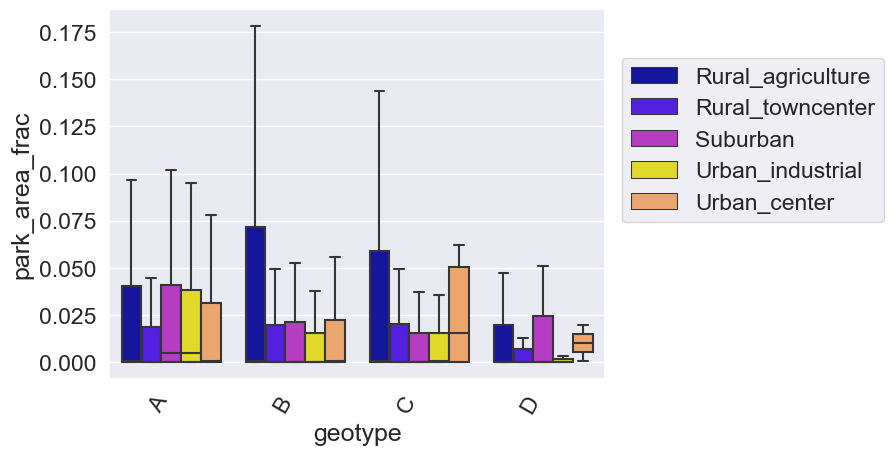

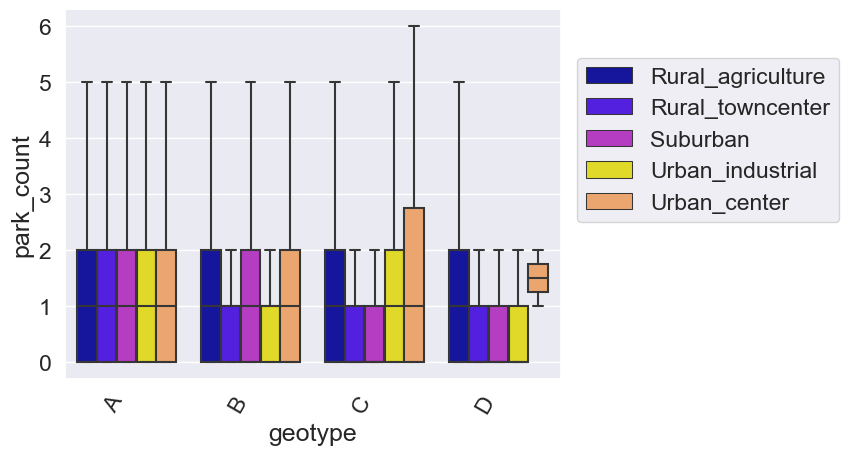

In [57]:
sns.boxplot(data = opportunity_and_jobs_typology, 
            x="geotype", y="park_area_frac", 
            hue = 'demand_microtype',        
            hue_order = order_demand,
            order = order_geotype, palette = sns.color_palette(palette, 5),
            showfliers = False)
plt.legend(bbox_to_anchor = (1.01, 0.9))
plt.xticks(rotation = 60, ha = 'right')
plt.savefig('plot/parks_area_frac_by_geotype_demand.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

sns.boxplot(data = opportunity_and_jobs_typology, 
            x="geotype", y="park_count", 
            hue = 'demand_microtype',        
            hue_order = order_demand,
            order = order_geotype, palette = sns.color_palette(palette, 5),
            showfliers = False)
plt.legend(bbox_to_anchor = (1.01, 0.9))
plt.xticks(rotation = 60, ha = 'right')
plt.savefig('plot/parks_count_by_geotype_demand.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

# part 2 -- explore trip rate

In [58]:
# get overall sample size
grouping_var = ['o_geotype', 'o_demand_microtype', 'o_network_microtype',
               'd_geotype', 'd_demand_microtype', 'd_network_microtype']
nhts_sample_by_od = pd.pivot_table(nhts_trip_rate,
                                   values='person_id', 
                                   index=grouping_var,
                                   columns=['mode'], aggfunc="count", 
                                   fill_value=0)
nhts_sample_by_od.loc[:, 'total_sample'] = nhts_sample_by_od.sum(axis = 1)
nhts_sample_by_od = nhts_sample_by_od.reset_index()
nhts_sample_by_od.to_csv('data/nhts_sample_size_by_od.csv')
nhts_sample_by_od.head(5)

mode,o_geotype,o_demand_microtype,o_network_microtype,d_geotype,d_demand_microtype,d_network_microtype,bike,bus,hv,rail,taxi,walk,total_sample
0,A,Rural_agriculture,Urban_2,A,Rural_agriculture,Urban_2,0,0,189,0,0,34,223
1,A,Rural_agriculture,Urban_2,A,Rural_agriculture,Urban_5,0,0,10,0,0,0,10
2,A,Rural_agriculture,Urban_2,A,Rural_towncenter,Urban_2,0,0,1,0,0,0,1
3,A,Rural_agriculture,Urban_2,A,Rural_towncenter,Urban_4,0,0,4,0,0,0,4
4,A,Rural_agriculture,Urban_2,A,Rural_towncenter,Urban_5,0,0,57,0,0,0,57


In [68]:
# generate trip rate
grouping_var = ['h_geotype', 'h_demand_microtype', 
                'trip_purpose', 'trip_purpose_agg', 'populationgroupid']
pop_grouping_var = ['h_geotype', 'h_demand_microtype', 'populationgroupid']

pop_group_mapping = {
    'HighIncVehSenior': 'HighIncVeh', 
    'HighIncVeh': 'HighIncVeh', 
    'LowIncVehSenior': 'LowIncVeh', 
    'LowIncVeh': 'LowIncVeh',
    'LowIncNoVeh': 'LowIncNoVeh', 
    'LowIncNoVehSenior': 'LowIncNoVeh', 
    'HighIncNoVeh': 'HighIncNoVeh',
    'HighIncNoVehSenior': 'HighIncNoVeh'
    }

# redo the mapping to align with mode choice model
nhts_population.loc[:, 'populationgroupid'] = \
    nhts_population.loc[:, 'populationgroupid'].map(pop_group_mapping)
nhts_trip_rate.loc[:, 'populationgroupid'] = \
    nhts_trip_rate.loc[:, 'populationgroupid'].map(pop_group_mapping)

print(nhts_trip_rate.populationgroupid.unique())
trips_by_home_demand = nhts_trip_rate.groupby(grouping_var)[['wtperfin']].sum()
trips_by_home_demand.columns = ['trip_count']
trips_by_home_demand = trips_by_home_demand.reset_index()



pop_by_home_demand = nhts_population.groupby(pop_grouping_var)[['wtperfin']].sum()
pop_by_home_demand.columns = ['population']
pop_by_home_demand = pop_by_home_demand.reset_index()

ss_by_home_demand = nhts_population.groupby(pop_grouping_var)[['wtperfin']].count()
ss_by_home_demand.columns = ['person sample size']
ss_by_home_demand = ss_by_home_demand.reset_index()
trip_rate_by_home_demand = \
pd.merge(trips_by_home_demand, pop_by_home_demand,
        on = pop_grouping_var, how = 'left')

trip_rate_by_home_demand = \
pd.merge(trip_rate_by_home_demand, ss_by_home_demand,
        on = pop_grouping_var, how = 'left')
print(len(trip_rate_by_home_demand))
trip_rate_by_home_demand.head(5)
# person_by_home_loc = \
# nhts_trip_rate[['HOUSEID', 'PERSON_ID', 'h_geotype',
#                 'h_network_microtype', 'h_demand_microtype']]
# person_by_home_loc = person_by_home_loc.drop_duplicates(keep = 'first')
# print(len(person_by_home_loc))

['HighIncVeh' 'LowIncVeh' 'LowIncNoVeh' 'HighIncNoVeh']
585


,h_geotype,h_demand_microtype,trip_purpose,trip_purpose_agg,populationgroupid,trip_count,population,person sample size
0,A,Rural_agriculture,home,home,HighIncNoVeh,8.033149e+02,3.733369e+02,4
1,A,Rural_agriculture,home,home,HighIncVeh,2.319277e+06,2.079548e+06,1934
2,A,Rural_agriculture,home,home,LowIncNoVeh,3.438017e+04,2.972074e+04,29
3,A,Rural_agriculture,home,home,LowIncVeh,5.852950e+05,6.283316e+05,666
4,A,Rural_agriculture,meals,shopping_meals,HighIncNoVeh,2.327822e+02,3.733369e+02,4


check missing values in data:
h_geotype             0
h_demand_microtype    0
trip_purpose          0
trip_purpose_agg      0
populationgroupid     0
trip_count            0
population            0
person sample size    0
trip_per_person       0
dtype: int64
0.00029784111800256575
4.0


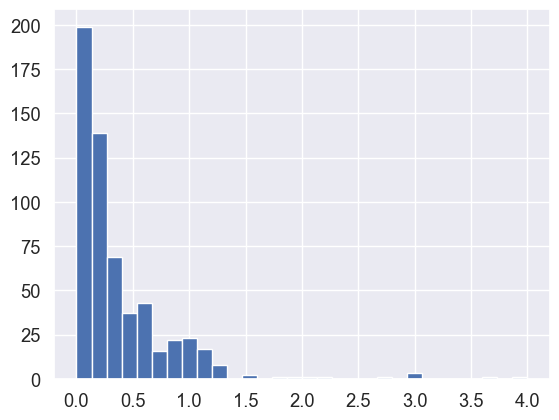

In [69]:
trip_rate_by_home_demand.loc[:, 'trip_per_person'] = \
trip_rate_by_home_demand.loc[:, 'trip_count'] / \
trip_rate_by_home_demand.loc[:, 'population']

print('check missing values in data:')
print(trip_rate_by_home_demand.isna().sum())

trip_rate_by_home_demand.loc[:, 'trip_per_person'].hist(bins = 30)
print(trip_rate_by_home_demand.loc[:, 'trip_per_person'].min())
print(trip_rate_by_home_demand.loc[:, 'trip_per_person'].max())

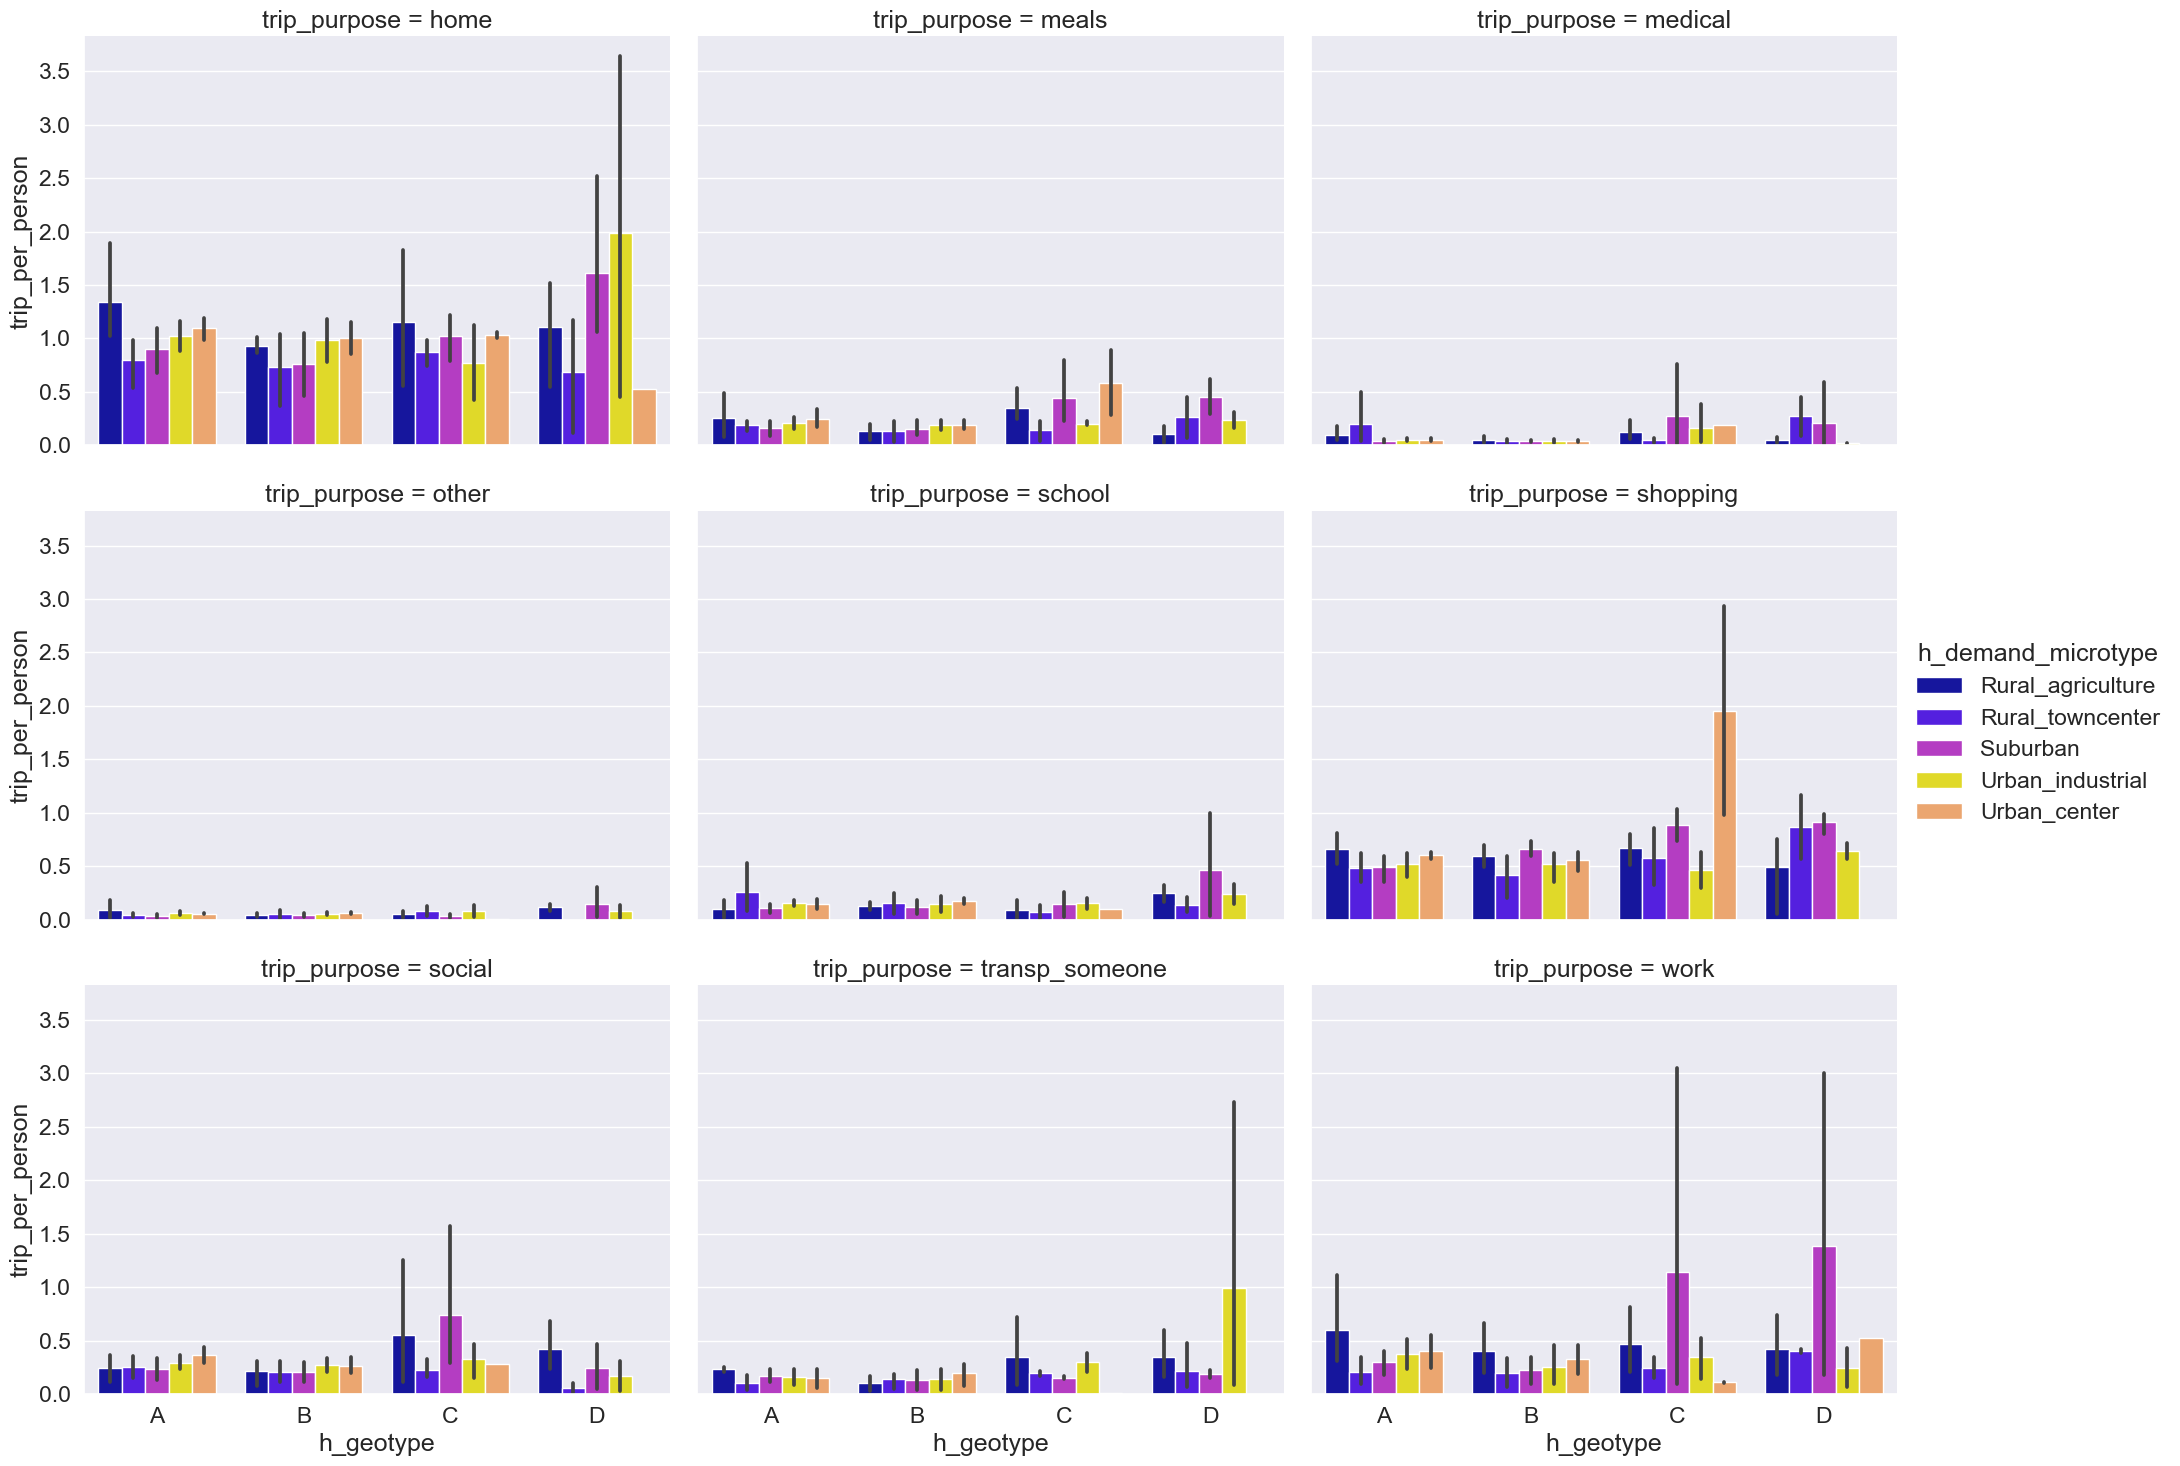

In [71]:
# trip rate by geotype X demand
sns.set(font_scale=1.5)  # crazy big

ax = sns.catplot(data = trip_rate_by_home_demand, 
            hue_order = order_demand,
            order = order_geotype,
            x="h_geotype", y="trip_per_person", 
            hue = 'h_demand_microtype', col="trip_purpose", 
            col_wrap = 3, kind="bar", palette = sns.color_palette(palette, 5),
            height = 5, aspect = 1.3, 
            sharey = True)

# ax.set_titles("{col_name}")
# plt.xticks(rotation = 30, ha= 'right')
for axn in ax.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(0)
        
plt.savefig('plot/trip_rate_by_purpose_home_geotype_demand.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

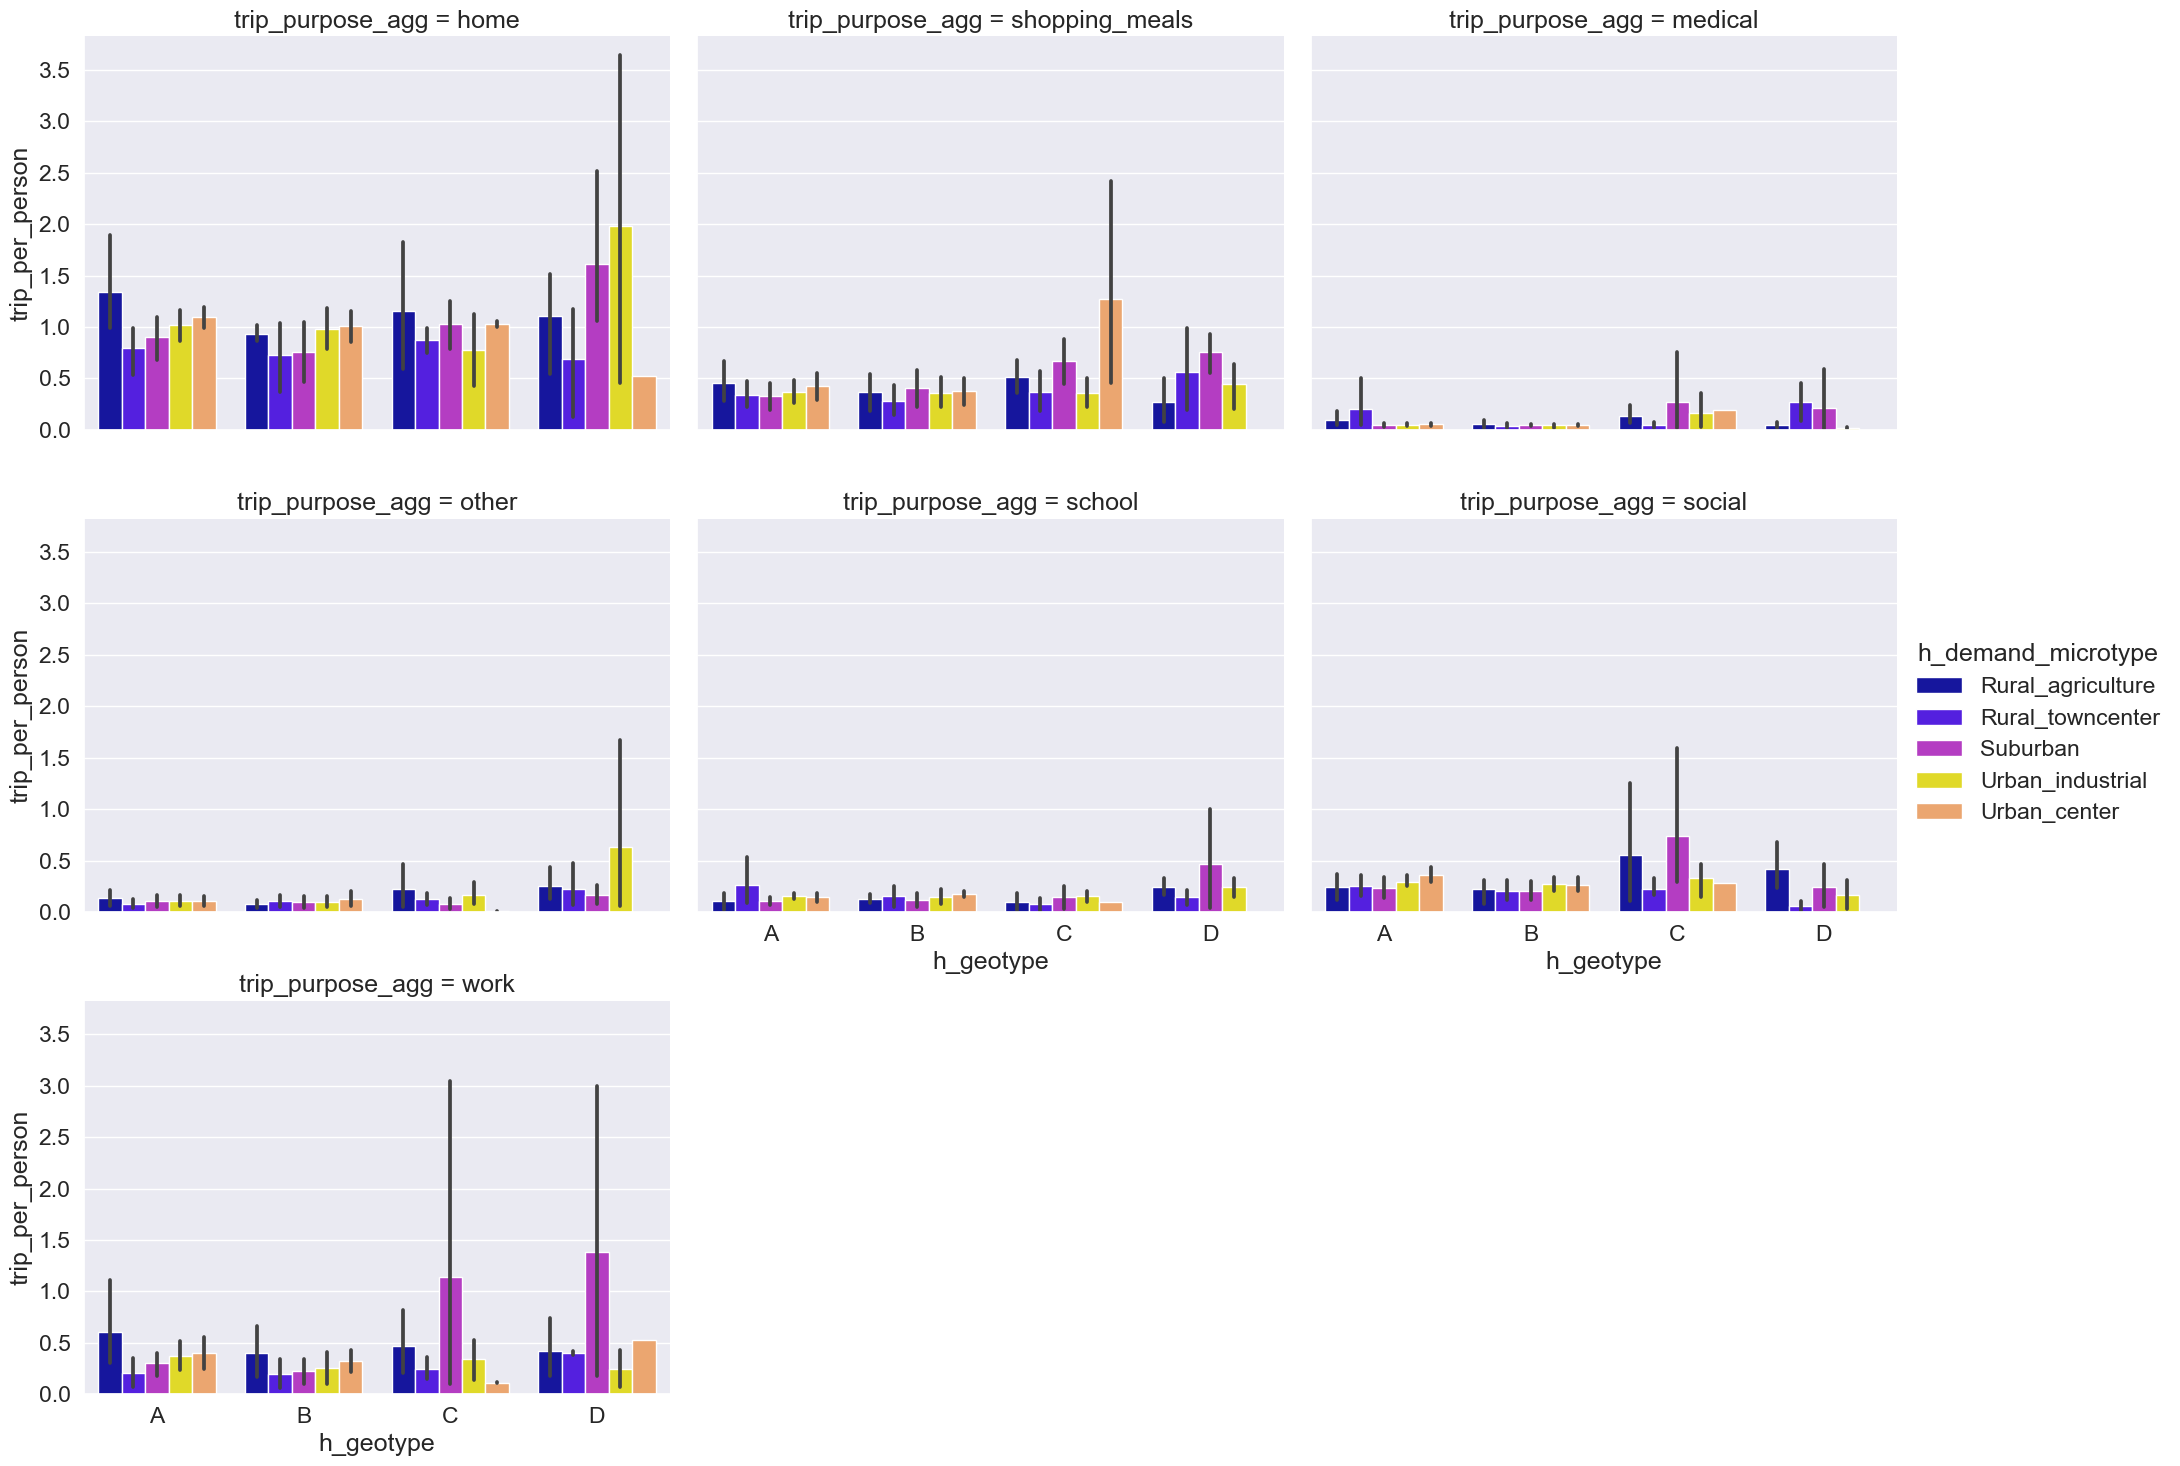

In [72]:
ax = sns.catplot(data = trip_rate_by_home_demand, 
            hue_order = order_demand,
            order = order_geotype,
            x="h_geotype", y="trip_per_person", 
            hue = 'h_demand_microtype', col="trip_purpose_agg", 
            col_wrap = 3, kind="bar", palette = sns.color_palette(palette, 5),
            height = 5, aspect = 1.3, 
            sharey = True)

# ax.set_titles("{col_name}")
# plt.xticks(rotation = 30, ha= 'right')
for axn in ax.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(0)
        
plt.savefig('plot/trip_rate_by_purpose_home_geotype_demand_agg.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

585
check missing values in data:
h_geotype             0
h_demand_microtype    0
populationgroupid     0
trip_count            0
population            0
person sample size    0
trip_per_person       0
dtype: int64
0.240331230648737
10.0


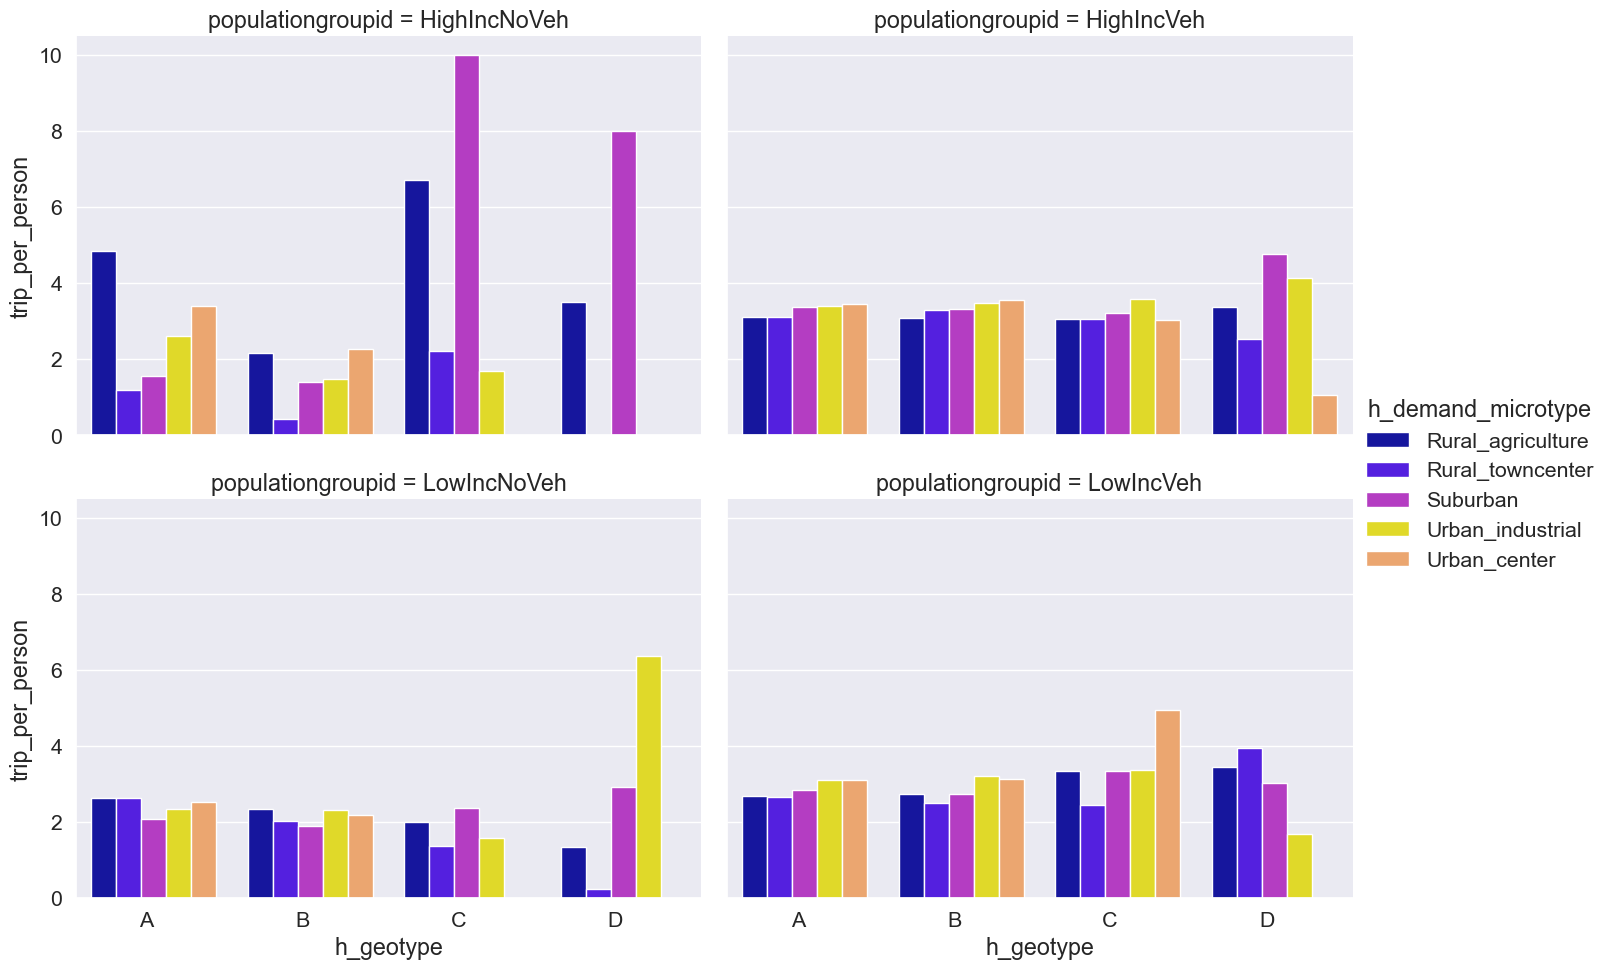

In [73]:
# trip rate by geotype X demand -> drop trip purpose
trips_by_home_demand_nopurp = nhts_trip_rate.groupby(pop_grouping_var)[['wtperfin']].sum()
trips_by_home_demand_nopurp.columns = ['trip_count']
trips_by_home_demand_nopurp = trips_by_home_demand_nopurp.reset_index()

trip_rate_by_home_demand_nopurp = \
pd.merge(trips_by_home_demand_nopurp, pop_by_home_demand,
        on = pop_grouping_var, how = 'left')

trip_rate_by_home_demand_nopurp = \
pd.merge(trip_rate_by_home_demand_nopurp, ss_by_home_demand,
        on = pop_grouping_var, how = 'left')
print(len(trip_rate_by_home_demand))

trip_rate_by_home_demand_nopurp.loc[:, 'trip_per_person'] = \
trip_rate_by_home_demand_nopurp.loc[:, 'trip_count'] / \
trip_rate_by_home_demand_nopurp.loc[:, 'population']

print('check missing values in data:')
print(trip_rate_by_home_demand_nopurp.isna().sum())

print(trip_rate_by_home_demand_nopurp.loc[:, 'trip_per_person'].min())
print(trip_rate_by_home_demand_nopurp.loc[:, 'trip_per_person'].max())

sns.set(font_scale=1.4)  # crazy big

g = sns.catplot(data = trip_rate_by_home_demand_nopurp, 
            hue_order = order_demand,
            order = order_geotype,
            x="h_geotype", y="trip_per_person", 
            hue = 'h_demand_microtype', col= "populationgroupid", 
            col_wrap = 2, kind="bar", 
            height = 5, aspect = 1.4, palette = sns.color_palette(palette, 5),
            sharey = True)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
        label.set_ha("right")
        
plt.savefig('plot/trip_rate_by_group_home_geotype_demand.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

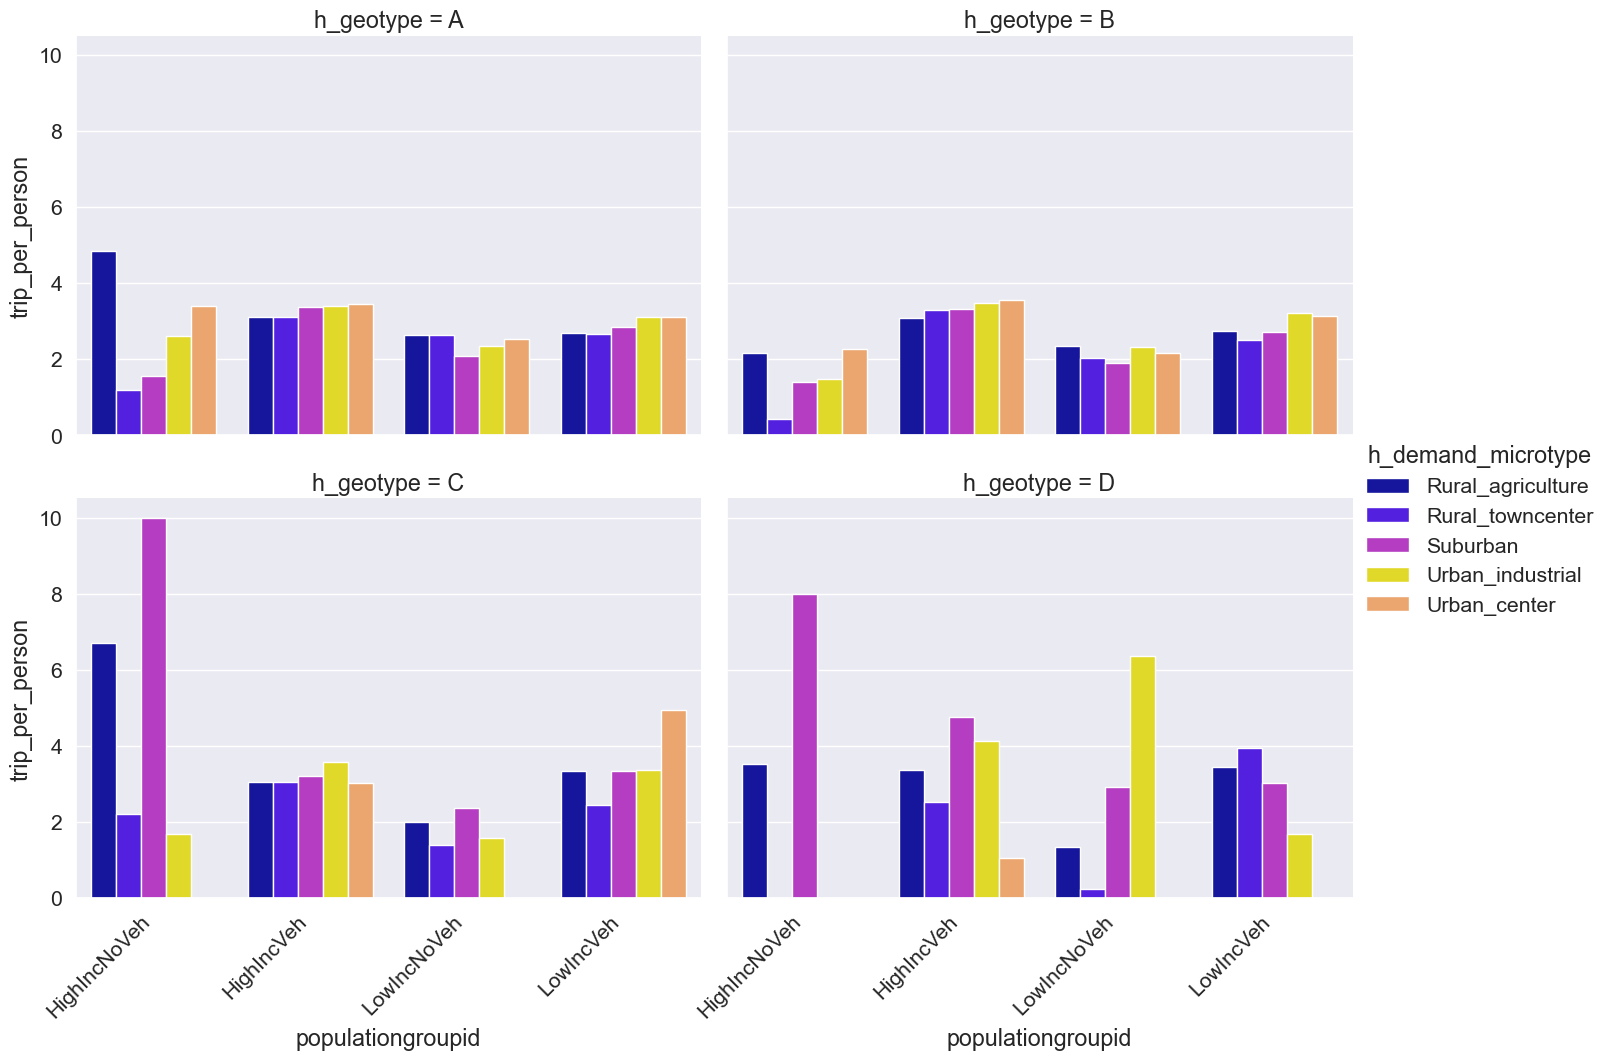

In [64]:
g = sns.catplot(data = trip_rate_by_home_demand_nopurp, 
            hue_order = order_demand,
            # order = order_geotype,
            x= "populationgroupid",  y="trip_per_person", 
            hue = 'h_demand_microtype', col= "h_geotype",
            col_wrap = 2, kind="bar", palette = sns.color_palette(palette, 5),
            height = 5, aspect = 1.4, 
            sharey = True)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")
        
plt.savefig('plot/trip_rate_by_group_home_geotype_demand_rotated.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

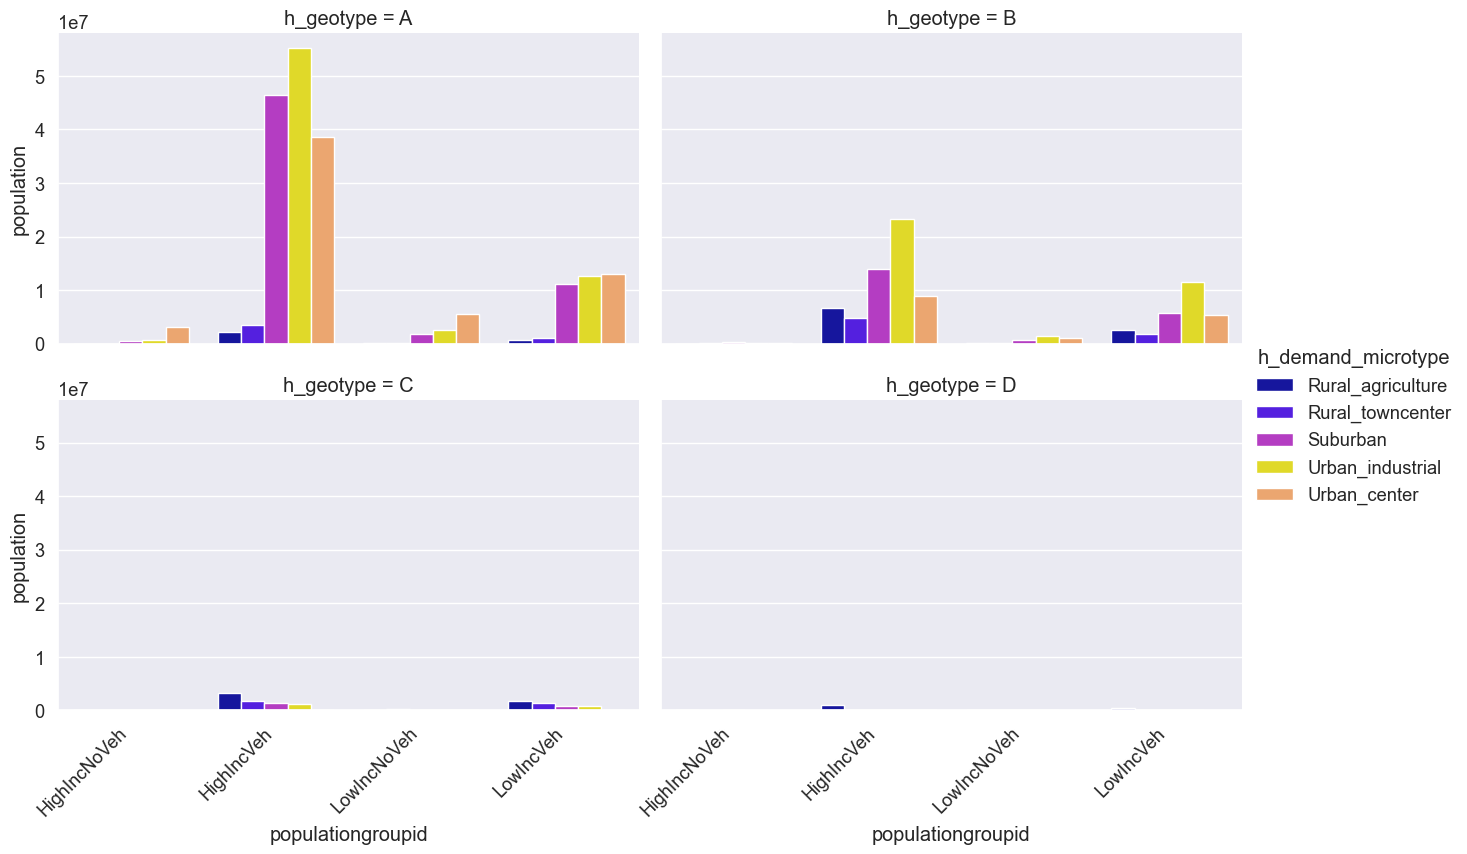

,h_geotype,h_demand_microtype,populationgroupid,population
0,A,Rural_agriculture,HighIncNoVeh,3.733369e+02
1,A,Rural_agriculture,HighIncVeh,2.079548e+06
2,A,Rural_agriculture,LowIncNoVeh,2.972074e+04
3,A,Rural_agriculture,LowIncVeh,6.283316e+05
4,A,Rural_towncenter,HighIncNoVeh,1.060623e+04


In [65]:
# population
sns.set(font_scale=1.2)  
g= sns.catplot(data = pop_by_home_demand, 
            hue_order = order_demand,
            # order = order_geotype,
            x = 'populationgroupid', 
            y = "population", 
            hue = 'h_demand_microtype', palette = sns.color_palette(palette, 5),
            col="h_geotype", col_wrap = 2, height = 4, aspect = 1.6,
            kind = 'bar', sharey = True)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

# g.set_xticklabels(rotation=45, ha="right")
plt.savefig('plot/population_by_home_geotype_demand.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()
pop_by_home_demand.head(5)

In [66]:
# generate trip rate + network
grouping_var = ['h_geotype', 'h_network_microtype', 
                'trip_purpose', 'trip_purpose_agg', 'populationgroupid']
pop_grouping_var = ['h_geotype', 'h_network_microtype', 'populationgroupid']
trips_by_home_network = nhts_trip_rate.groupby(grouping_var)[['wtperfin']].sum()
trips_by_home_network.columns = ['trip_count']
trips_by_home_network = trips_by_home_network.reset_index()

pop_by_home_network = nhts_population.groupby(pop_grouping_var)[['wtperfin']].sum()
pop_by_home_network.columns = ['population']
pop_by_home_network = pop_by_home_network.reset_index()

ss_by_home_network = nhts_population.groupby(pop_grouping_var)[['wtperfin']].count()
ss_by_home_network.columns = ['person sample size']
ss_by_home_network = ss_by_home_network.reset_index()
trip_rate_by_home_network = \
pd.merge(trips_by_home_network, pop_by_home_network,
        on = pop_grouping_var, how = 'left')

trip_rate_by_home_network = \
pd.merge(trip_rate_by_home_network, ss_by_home_network,
        on = pop_grouping_var, how = 'left')
print(len(trip_rate_by_home_network))
trip_rate_by_home_network.head(5)

530


,h_geotype,h_network_microtype,trip_purpose,trip_purpose_agg,populationgroupid,trip_count,population,person sample size
0,A,Urban_1,home,home,HighIncNoVeh,3.483416e+06,3.210012e+06,949
1,A,Urban_1,home,home,HighIncVeh,2.798846e+07,2.237971e+07,14524
2,A,Urban_1,home,home,LowIncNoVeh,4.534775e+06,4.899574e+06,1312
3,A,Urban_1,home,home,LowIncVeh,7.766181e+06,6.892093e+06,3379
4,A,Urban_1,meals,shopping_meals,HighIncNoVeh,1.245177e+06,3.210012e+06,949


check missing values in data:
h_geotype              0
h_network_microtype    0
trip_purpose           0
trip_purpose_agg       0
populationgroupid      0
trip_count             0
population             0
person sample size     0
trip_per_person        0
dtype: int64
0.0006144093293689186
3.6716582402059563


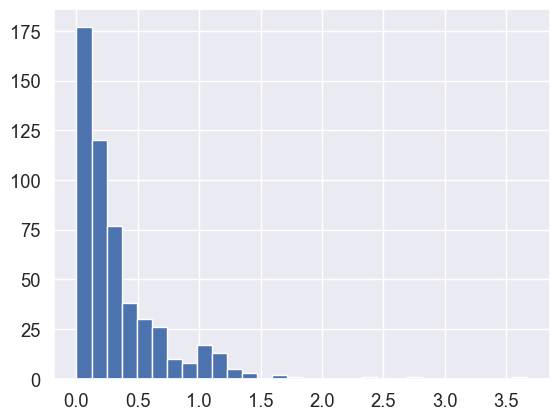

In [25]:
trip_rate_by_home_network.loc[:, 'trip_per_person'] = \
trip_rate_by_home_network.loc[:, 'trip_count'] / \
trip_rate_by_home_network.loc[:, 'population']

print('check missing values in data:')
print(trip_rate_by_home_network.isna().sum())

trip_rate_by_home_network.loc[:, 'trip_per_person'].hist(bins = 30)
print(trip_rate_by_home_network.loc[:, 'trip_per_person'].min())
print(trip_rate_by_home_network.loc[:, 'trip_per_person'].max())

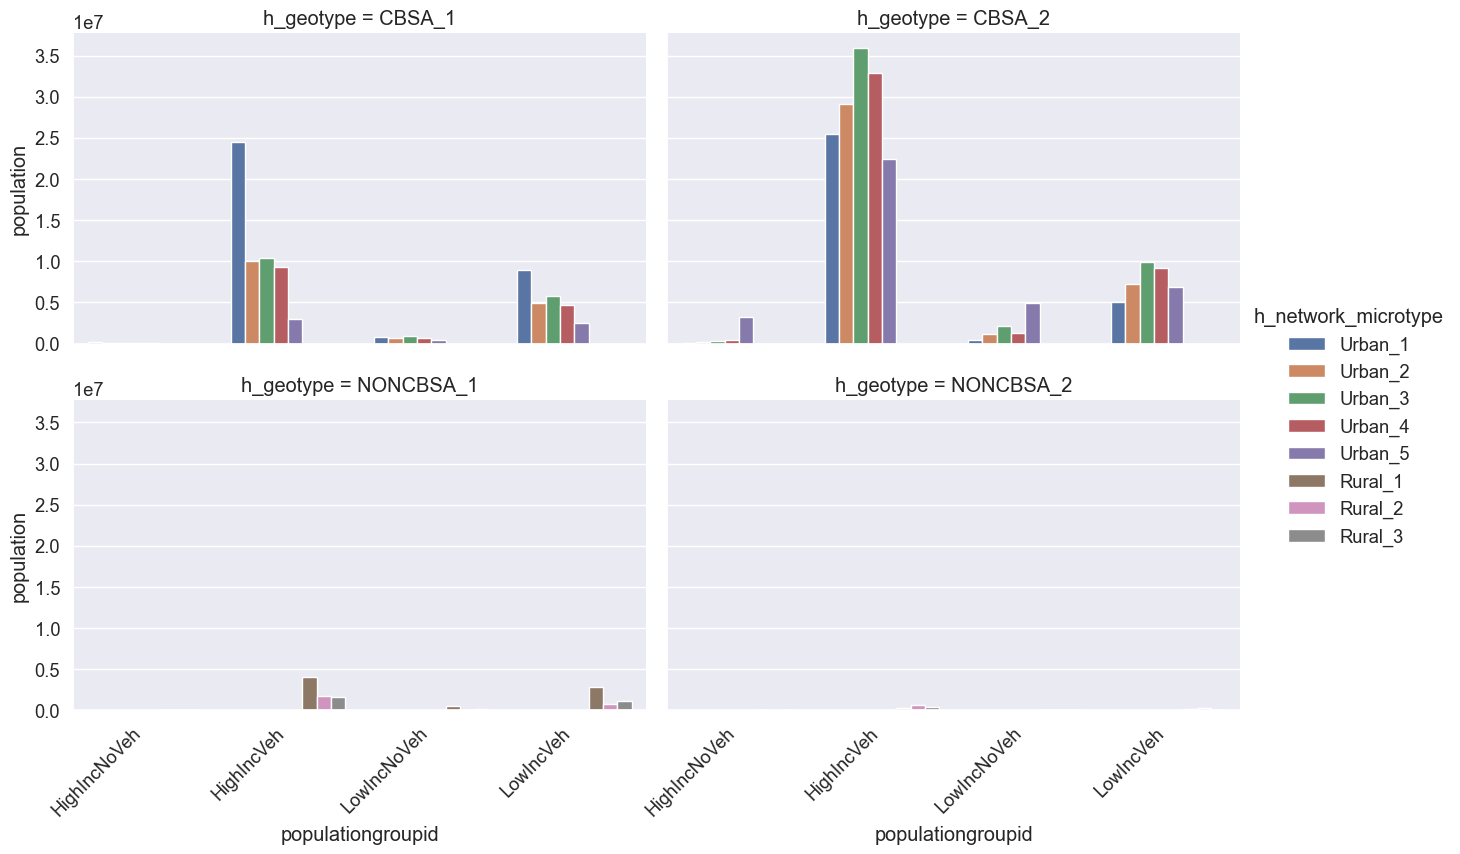

,h_geotype,h_network_microtype,populationgroupid,population
0,CBSA_1,Urban_1,HighIncNoVeh,2.332393e+05
1,CBSA_1,Urban_1,HighIncVeh,2.449360e+07
2,CBSA_1,Urban_1,LowIncNoVeh,8.157321e+05
3,CBSA_1,Urban_1,LowIncVeh,8.991378e+06
4,CBSA_1,Urban_2,HighIncNoVeh,7.037833e+04


In [26]:
# population
sns.set(font_scale=1.2)  
g= sns.catplot(data = pop_by_home_network, 
            hue_order = order_network,
            # order = order_geotype,
            x = 'populationgroupid', 
            y = "population", 
            hue = 'h_network_microtype', 
            col="h_geotype", col_wrap = 2, height = 4, aspect = 1.6,
            kind = 'bar', sharey = True)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

# g.set_xticklabels(rotation=45, ha="right")
plt.savefig('plot/population_by_home_geotype_network.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()
pop_by_home_network.head(5)

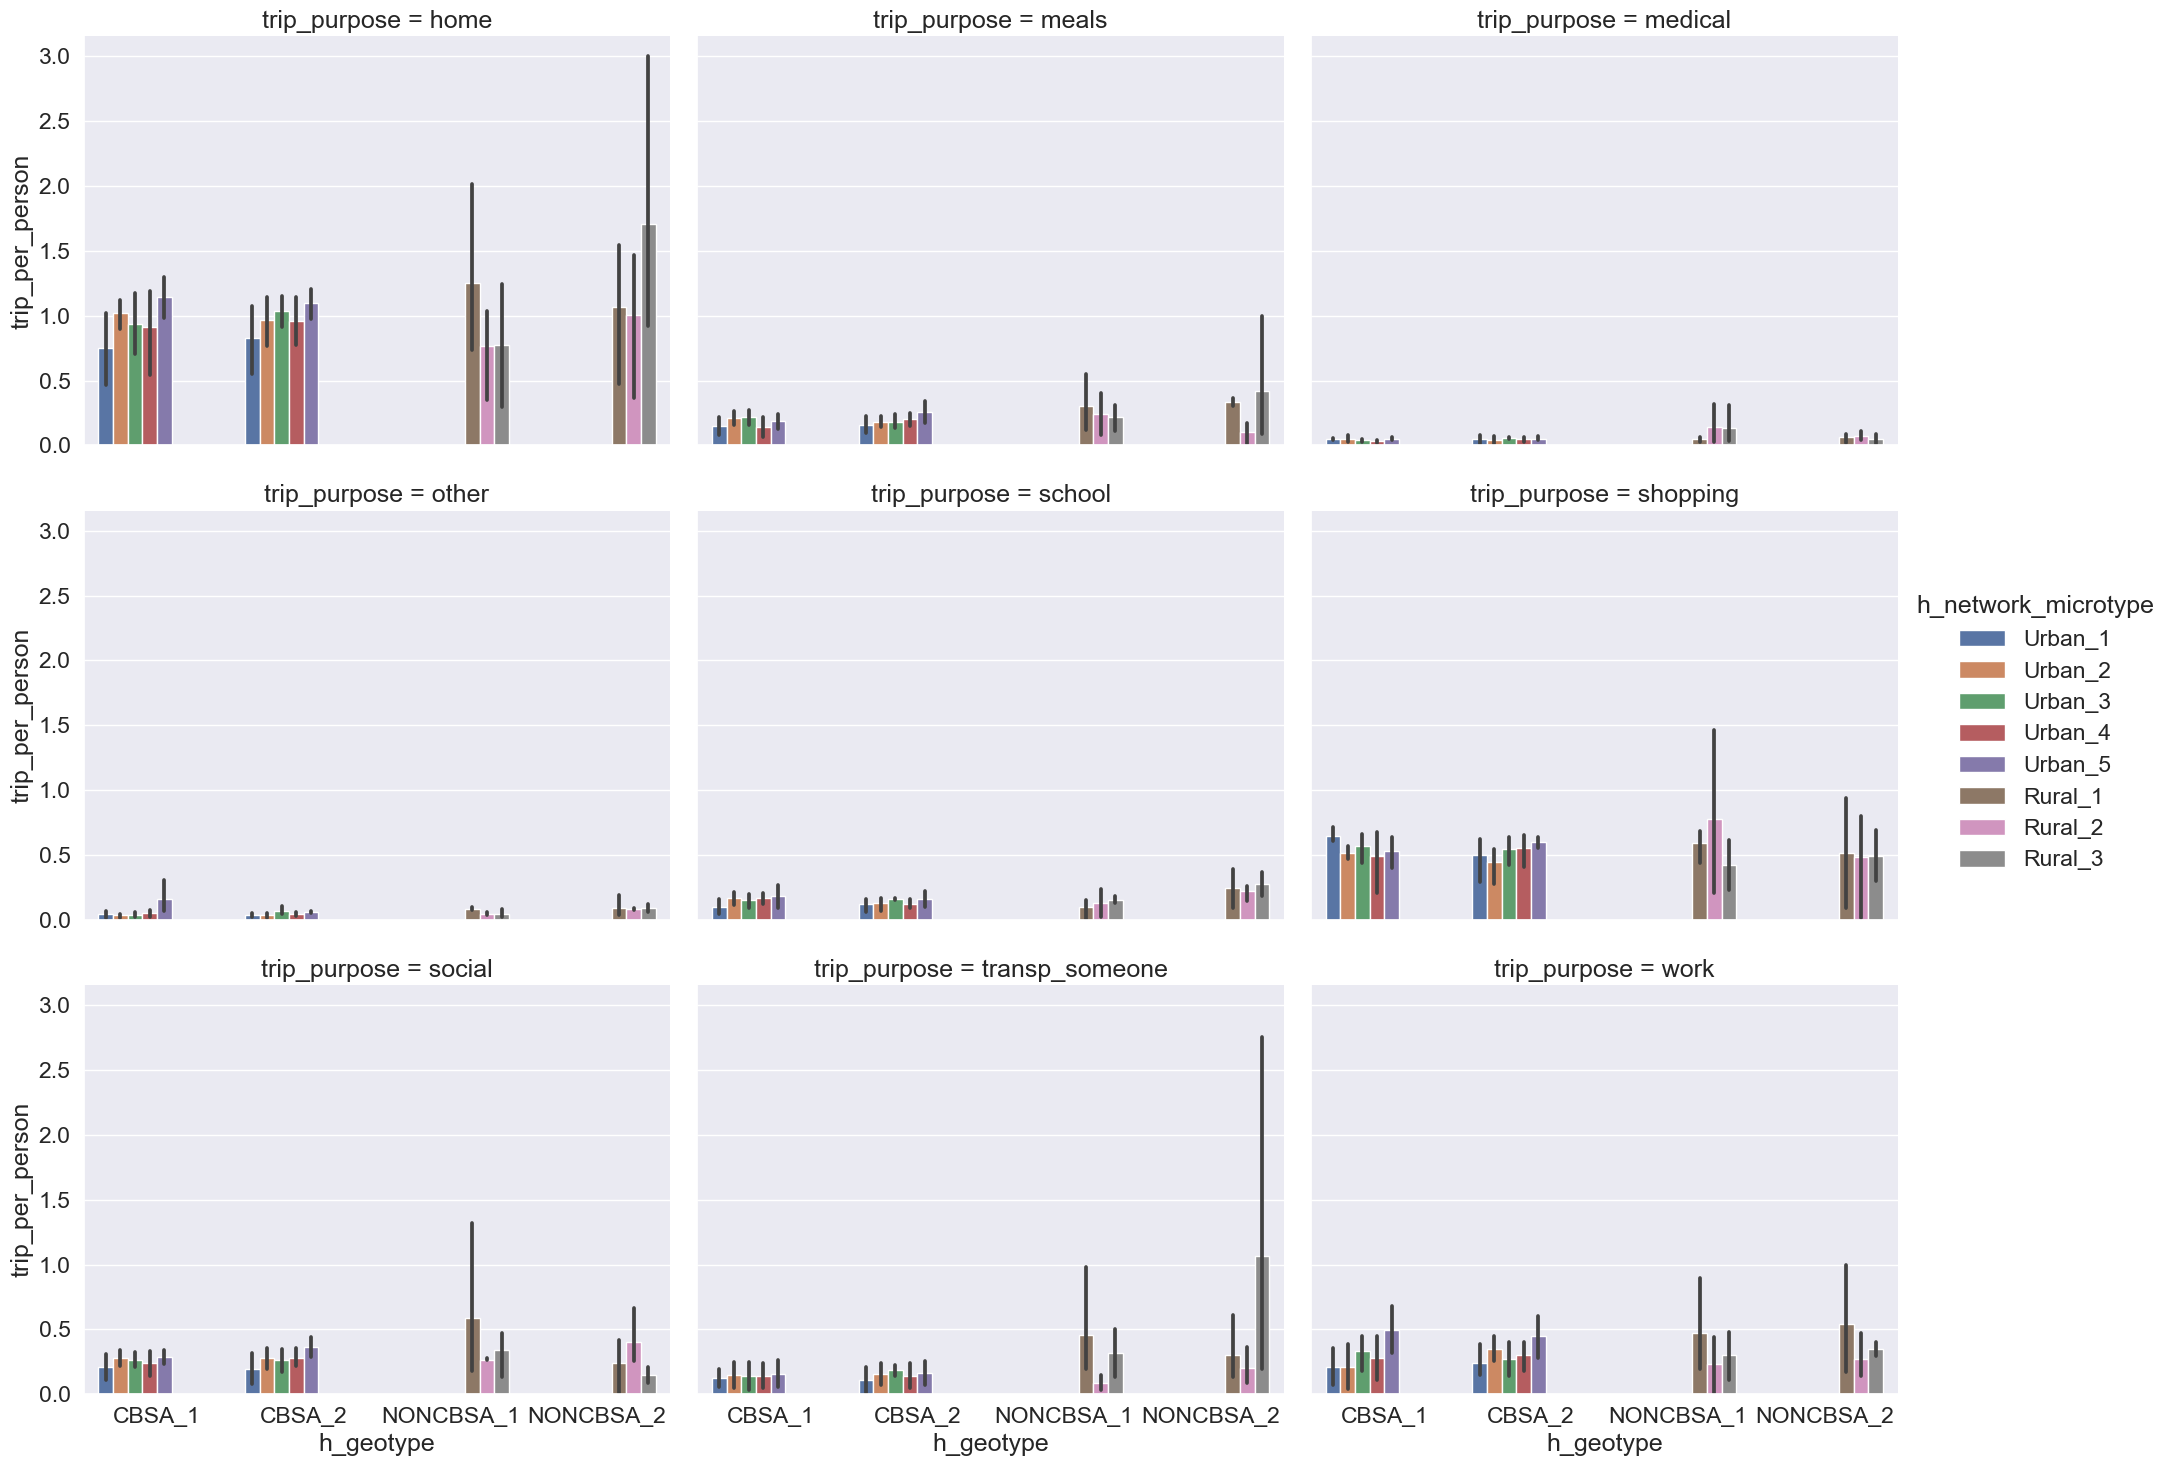

In [27]:
# trip rate by geotype X demand
sns.set(font_scale=1.5)  # crazy big

ax = sns.catplot(data = trip_rate_by_home_network, 
            hue_order = order_network,
            order = order_geotype,
            x="h_geotype", y="trip_per_person", 
            hue = 'h_network_microtype', col="trip_purpose", 
            col_wrap = 3, kind="bar", 
            height = 5, aspect = 1.3, 
            sharey = True)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha("right")
plt.savefig('plot/trip_rate_by_purpose_home_geotype_network.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

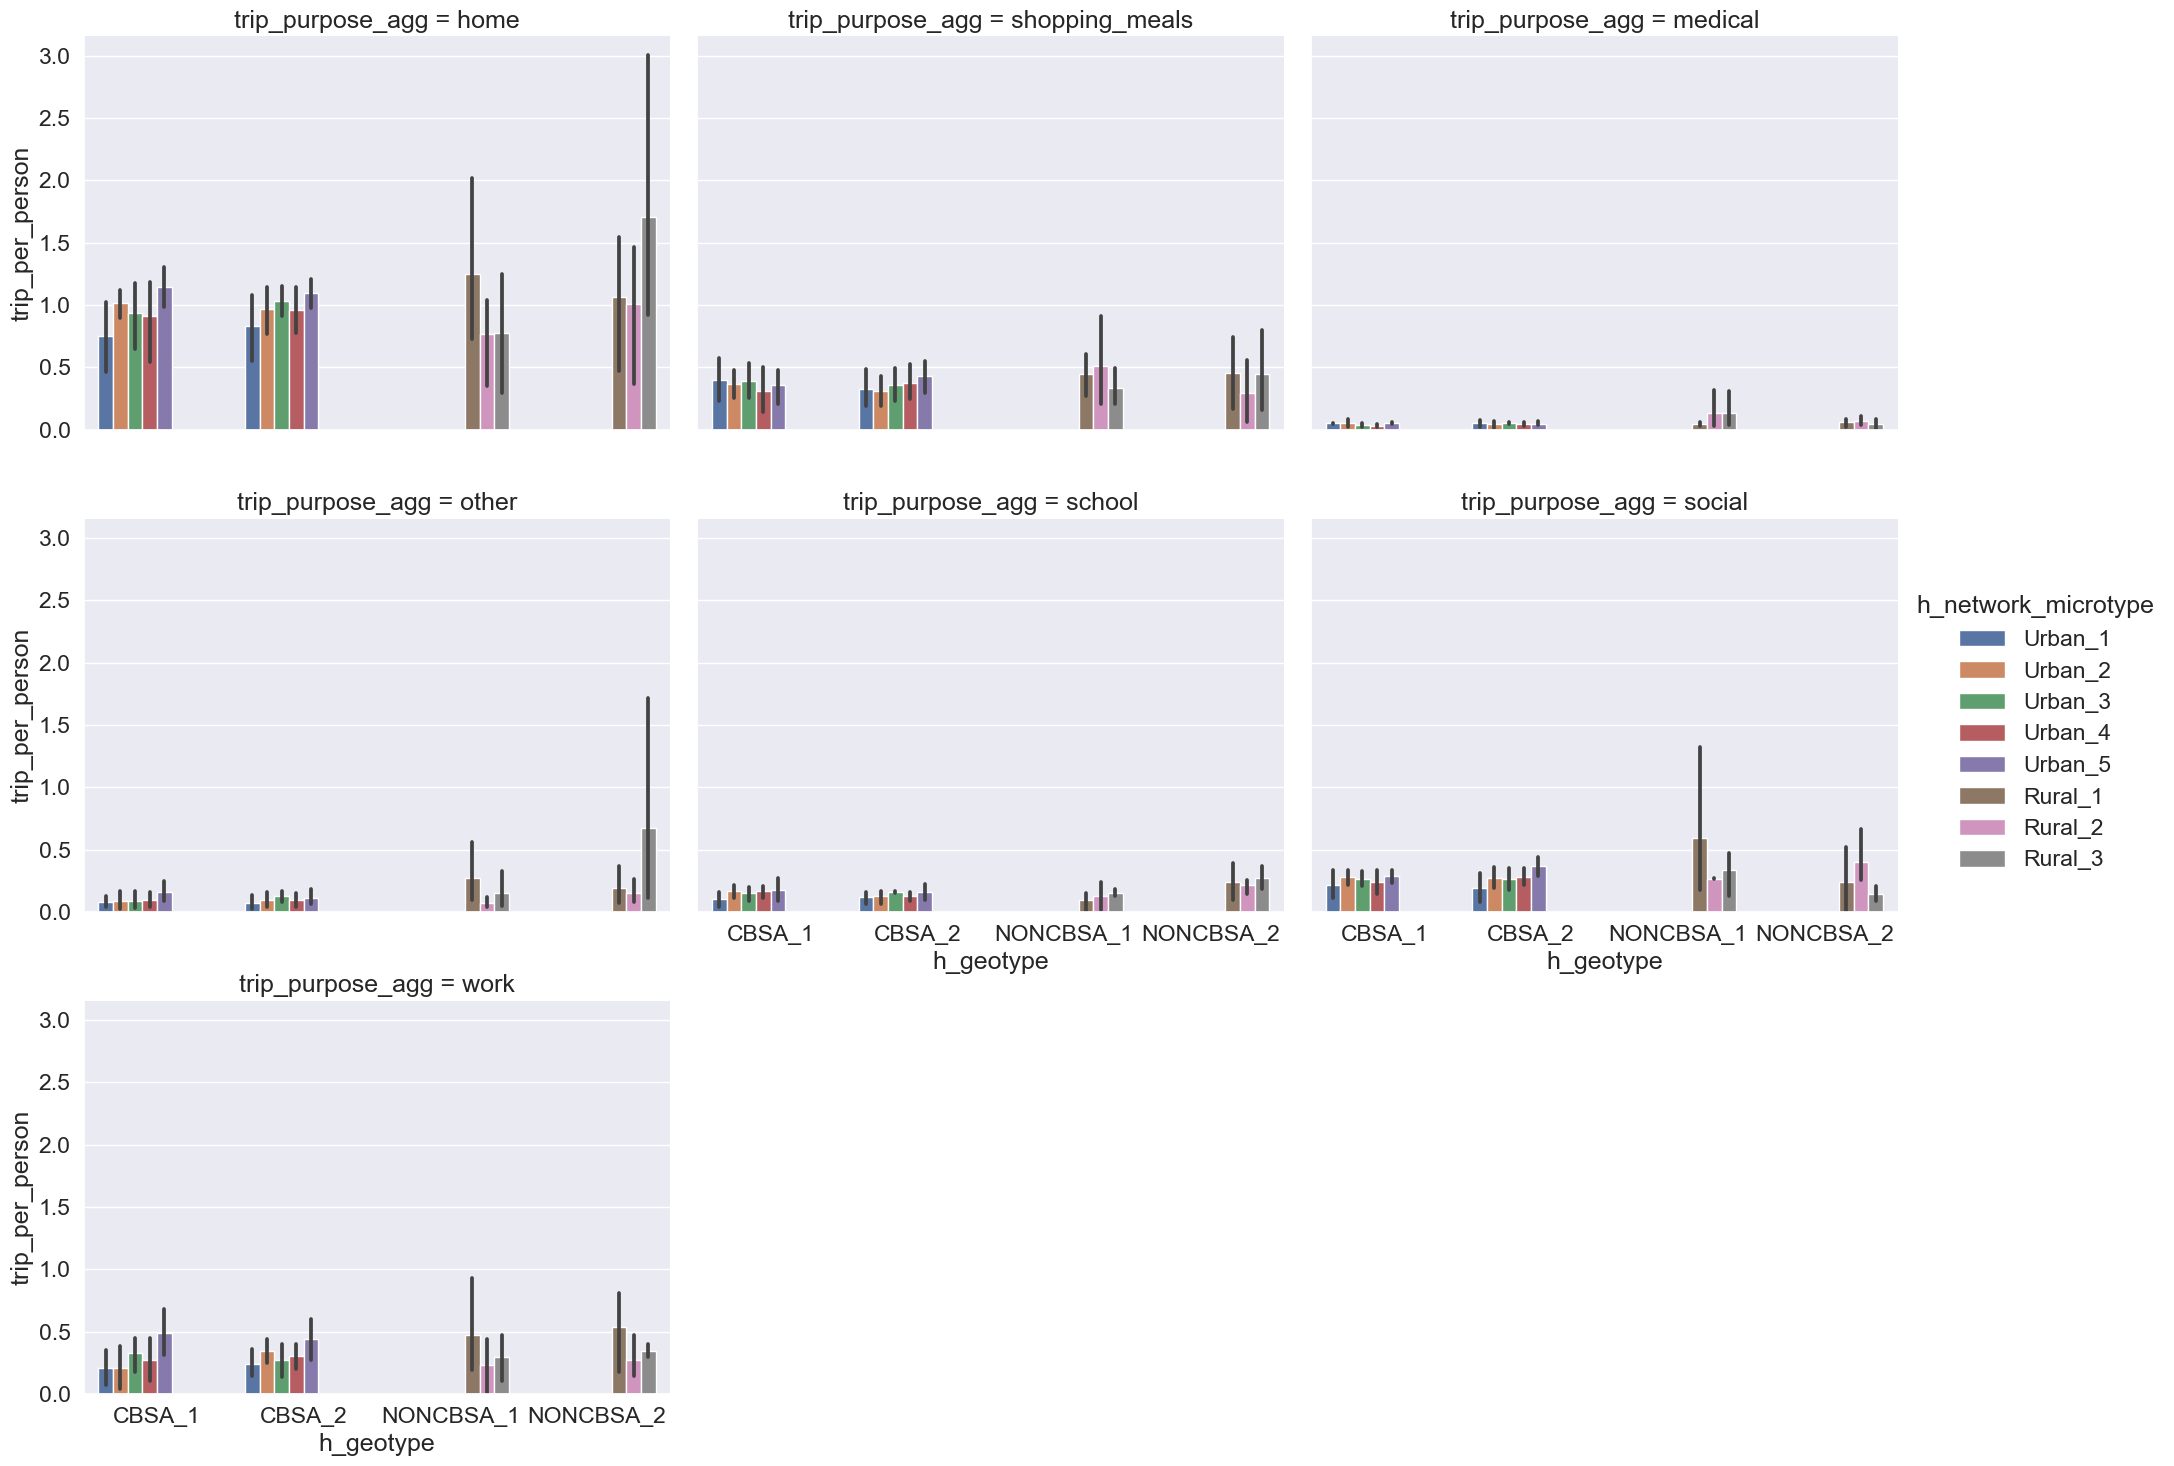

In [28]:
ax = sns.catplot(data = trip_rate_by_home_network, 
            hue_order = order_network,
            order = order_geotype,
            x="h_geotype", y="trip_per_person", 
            hue = 'h_network_microtype', col="trip_purpose_agg", 
            col_wrap = 3, kind="bar", 
            height = 5, aspect = 1.3, 
            sharey = True)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha("right")
plt.savefig('plot/trip_rate_by_purpose_home_geotype_network_agg.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

63
check missing values in data:
h_geotype              0
h_network_microtype    0
populationgroupid      0
trip_count             0
population             0
person sample size     0
trip_per_person        0
dtype: int64
0.2246419224777999
7.48144472858479


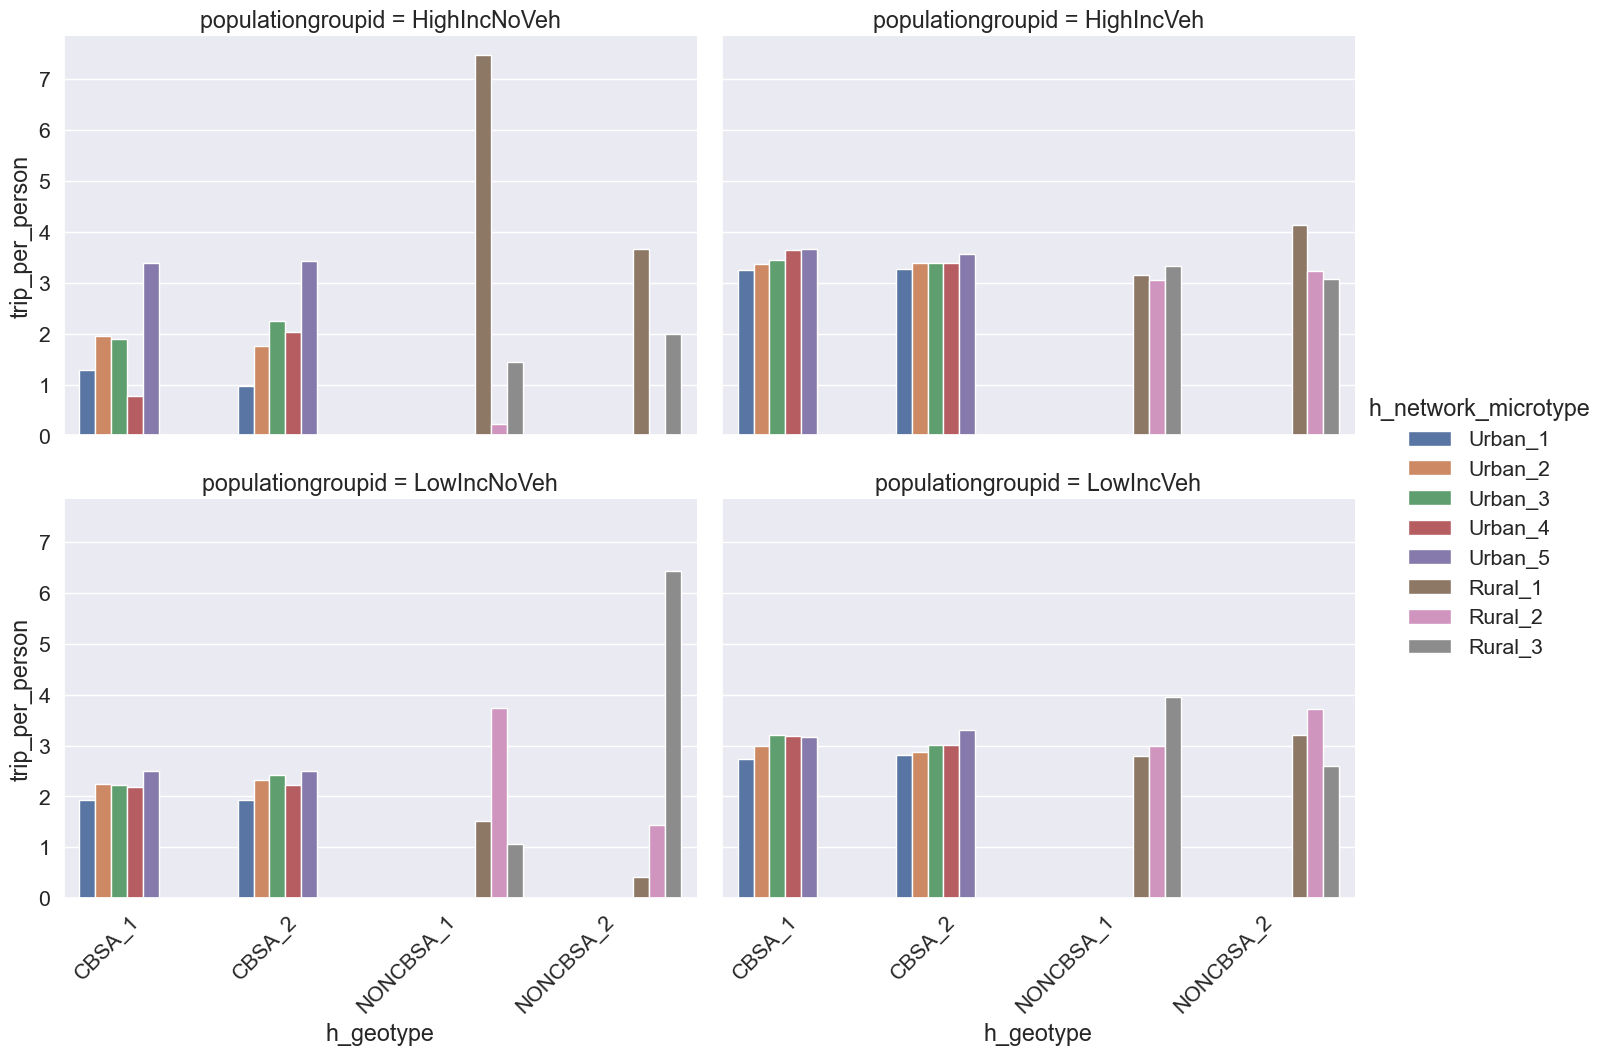

In [29]:
# trip rate by geotype X demand -> drop trip purpose
trips_by_home_network_nopurp = nhts_trip_rate.groupby(pop_grouping_var)[['wtperfin']].sum()
trips_by_home_network_nopurp.columns = ['trip_count']
trips_by_home_network_nopurp = trips_by_home_network_nopurp.reset_index()

trips_by_home_network_nopurp = \
pd.merge(trips_by_home_network_nopurp, pop_by_home_network,
        on = pop_grouping_var, how = 'left')

trips_by_home_network_nopurp = \
pd.merge(trips_by_home_network_nopurp, ss_by_home_network,
        on = pop_grouping_var, how = 'left')
print(len(trips_by_home_network_nopurp))

trips_by_home_network_nopurp.loc[:, 'trip_per_person'] = \
trips_by_home_network_nopurp.loc[:, 'trip_count'] / \
trips_by_home_network_nopurp.loc[:, 'population']

print('check missing values in data:')
print(trips_by_home_network_nopurp.isna().sum())

print(trips_by_home_network_nopurp.loc[:, 'trip_per_person'].min())
print(trips_by_home_network_nopurp.loc[:, 'trip_per_person'].max())

sns.set(font_scale=1.4)  # crazy big

g = sns.catplot(data = trips_by_home_network_nopurp, 
            hue_order = order_network,
            order = order_geotype,
            x="h_geotype", y="trip_per_person", 
            hue = 'h_network_microtype', col= "populationgroupid", 
            col_wrap = 2, kind="bar", 
            height = 5, aspect = 1.4, 
            sharey = True)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")
        
plt.savefig('plot/trip_rate_by_group_home_geotype_network.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

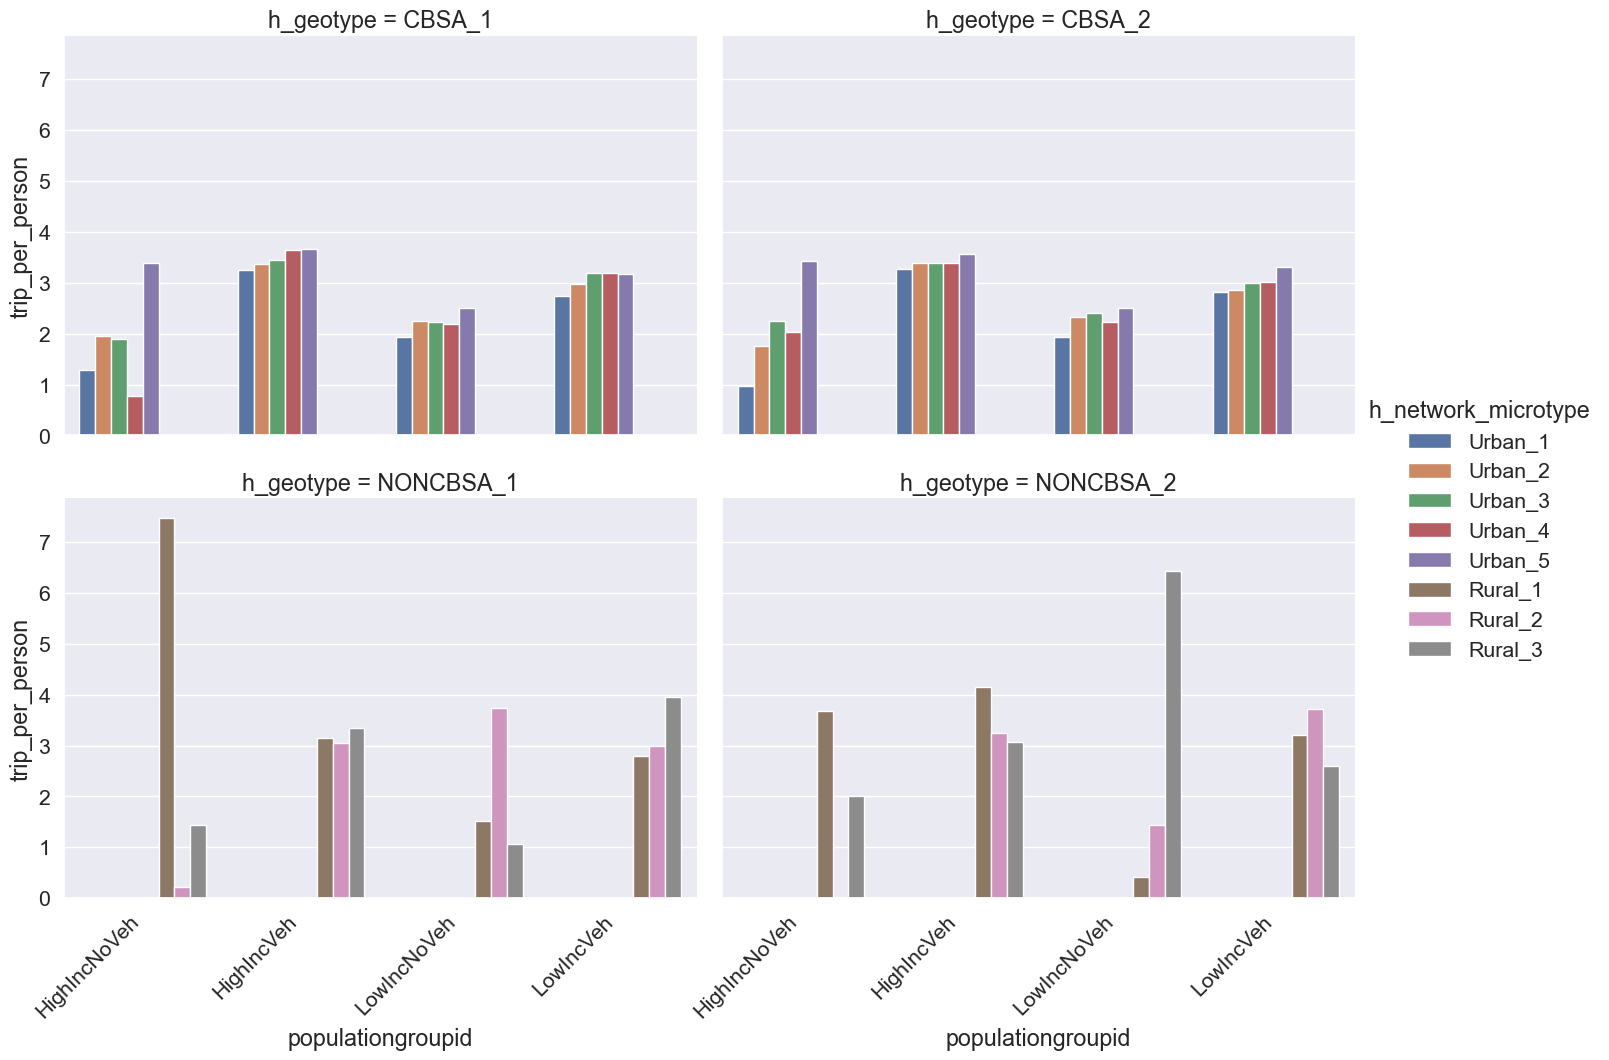

In [30]:
g = sns.catplot(data = trips_by_home_network_nopurp, 
            hue_order = order_network,
            # order = order_geotype,
            x= "populationgroupid",  y="trip_per_person", 
            hue = 'h_network_microtype', col= "h_geotype",
            col_wrap = 2, kind="bar", 
            height = 5, aspect = 1.4, 
            sharey = True)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")
        
plt.savefig('plot/trip_rate_by_group_home_geotype_network_rotated.png', dpi = 300,
           bbox_inches = 'tight')
plt.show()

In [33]:
typology_results_2020.columns
print(len(typology_results_2020.groupby(['geotype', 'demand_microtype_comb',
       'network_microtype']).size()))

77
